# Project 4: Quantifying Impact of EV Charging Stations on Air Quality

## Part III - Modeling

Authors: Aichieh Lin, Bede Young, and Charles Ramey

Date: 05/05/2023

---

#### Notebook Links

Part I - Project Intro & Data Cleaning
- [`Part-1_setup-and-clean.ipynb`](../code/Part-1_setup-and-clean.ipynb)

Part II - Exploratory Data Analysis (EDA)
- [`Part-2_eda.ipynb`](../code/Part-2_eda.ipynb)

Part III - Modeling
- [`Part-3.2_modeling.ipynb`](../code/Part-2_eda.ipynb)

Part IV - Conclusion, Recommendations, and Sources
- [`Part-4_conclusion-and-recommendations.ipynb`](../code/Part-4_conclusion-and-recommendations.ipynb)

In [74]:
import numpy as np
import pandas as pd

import requests
import os

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline

from datetime import datetime

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [75]:
# read data
df = pd.read_csv('../output/air_quality_by_county_daily.csv')

In [76]:
# Change date column to be datetime dtype
df['date'] = pd.to_datetime(df['date'])

In [93]:
df['state_name'].unique()

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District Of Columbia',
       'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
       'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'New York', 'North Carolina',
       'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming'], dtype=object)

In [77]:
df.head()

,state_name,county_name,date,aqi,category,defining_parameter
0,Alabama,Baldwin,2000-01-16,25,Good,PM2.5
1,Alabama,Baldwin,2000-01-19,46,Good,PM2.5
2,Alabama,Baldwin,2000-01-22,36,Good,PM2.5
3,Alabama,Baldwin,2000-01-25,26,Good,PM2.5
4,Alabama,Baldwin,2000-01-28,32,Good,PM2.5


In [78]:
df.describe().round(2)

,aqi
count,6965799.00
mean,42.84
std,32.07
min,0.00
25%,29.00
50%,39.00
75%,51.00
max,20646.00


In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6965799 entries, 0 to 6965798
Data columns (total 6 columns):
 #   Column              Dtype         
---  ------              -----         
 0   state_name          object        
 1   county_name         object        
 2   date                datetime64[ns]
 3   aqi                 int64         
 4   category            object        
 5   defining_parameter  object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 318.9+ MB


In [7]:
df_hazard = df[df['aqi'] > 500]

In [8]:
df_hazard['defining_parameter'].unique()

array(['PM10', 'PM2.5'], dtype=object)

In [9]:
df_hazard['defining_parameter'].value_counts()

PM10     480
PM2.5     34
Name: defining_parameter, dtype: int64

In [10]:
df_hazard['county_name'].value_counts()

Mono                     166
Inyo                     153
Pinal                     66
Washoe                    26
Dona Ana                  13
Luna                      10
Riverside                  7
Imperial                   6
El Paso                    5
Trinity                    4
Klickitat                  4
Marion                     4
Lane                       3
Kings                      3
Missoula                   3
Deschutes                  3
Platte                     3
Benton                     3
Walla Walla                3
Prowers                    2
Jefferson                  2
Campbell                   2
Ventura                    2
Tulare                     1
Jasper                     1
Sweetwater                 1
Stevens                    1
Maries                     1
Clark                      1
Linn                       1
Klamath                    1
Alamosa                    1
Jackson                    1
Maricopa                   1
Crook         

In [11]:
df_hazard['date'].value_counts()

2020-09-12    9
2020-09-13    7
2020-09-08    3
2012-03-18    3
2022-04-11    3
             ..
2006-02-14    1
2006-01-31    1
2006-01-23    1
2006-01-22    1
2022-02-19    1
Name: date, Length: 462, dtype: int64

In [80]:
df_daily_state = df.groupby(['state_name', 'date'])['aqi'].mean().reset_index()

In [81]:
df_daily_state.head()

,state_name,date,aqi
0,Alabama,2000-01-01,48.150000
1,Alabama,2000-01-02,39.333333
2,Alabama,2000-01-03,46.333333
3,Alabama,2000-01-04,30.076923
4,Alabama,2000-01-05,33.666667


In [82]:
df_daily_state.sort_values('aqi').tail()

,state_name,date,aqi
36810,California,2009-11-20,330.500000
34327,California,2003-02-02,351.622642
314164,Oregon,2020-09-13,374.136364
314163,Oregon,2020-09-12,403.652174
33686,California,2001-05-02,467.020000


In [83]:
df_daily_all = df_daily_state.groupby(['date'])['aqi'].mean().reset_index()

In [84]:
df_daily_all.head()

,date,aqi
0,2000-01-01,57.435300
1,2000-01-02,35.153369
2,2000-01-03,31.301916
3,2000-01-04,31.785806
4,2000-01-05,27.697871


In [85]:
df_daily_all.describe()

,aqi
count,8342.000000
mean,41.147542
std,8.438637
min,12.458333
25%,35.410050
50%,39.700597
75%,45.142269
max,92.006454


In [86]:
df_daily_all.shape

(8342, 2)

In [16]:
# Set the index to be date
df_daily_all.set_index('date', inplace=True)

In [17]:
df_daily_all.head(), df_daily_all.tail() 

(                  aqi
 date                 
 2000-01-01  57.435300
 2000-01-02  35.153369
 2000-01-03  31.301916
 2000-01-04  31.785806
 2000-01-05  27.697871,
                   aqi
 date                 
 2022-10-29  35.131624
 2022-10-30  34.232265
 2022-10-31  39.330769
 2022-11-01  12.458333
 2022-11-02  40.000000)

In [18]:
# adopted from class
# function for plot 

def plot_series(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
    
    # Set figure size to be (18, 9).
    plt.figure(figsize=(18,9))
    
    # Iterate through each column name.
    for col in cols:
        
        # Generate a line plot of the column name.
        # You only have to specify Y, since our
        # index will be a datetime index.
        plt.plot(df[col])
        
    # Generate title and labels.
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    # Enlarge tick marks.
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18);

### Daily Change in AQI, 2000 - 2022

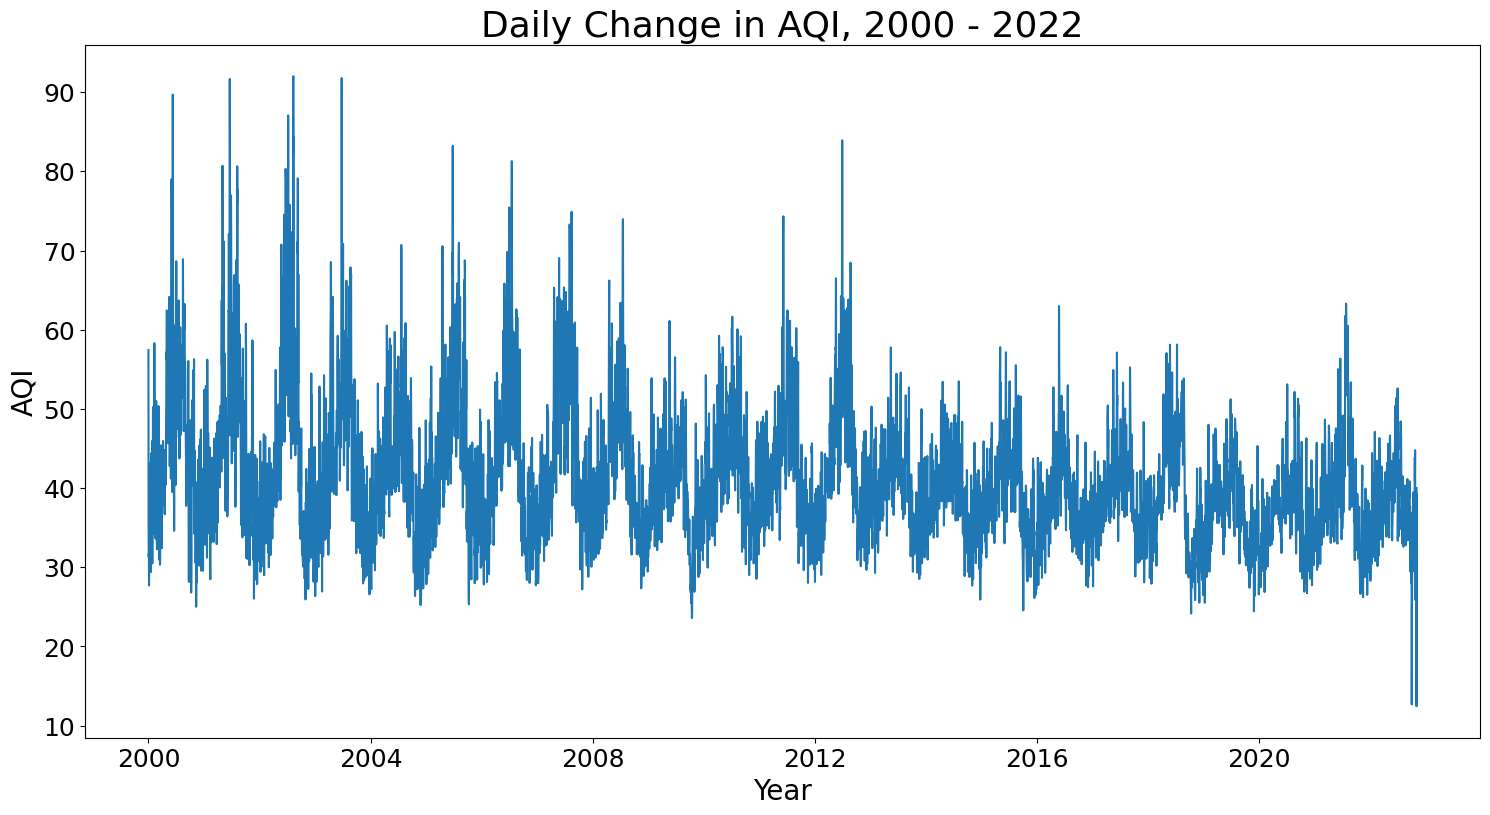

In [19]:
plot_series(df_daily_all, cols=['aqi'], title="Daily Change in AQI, 2000 - 2022", xlab='Year', ylab = 'AQI')

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose

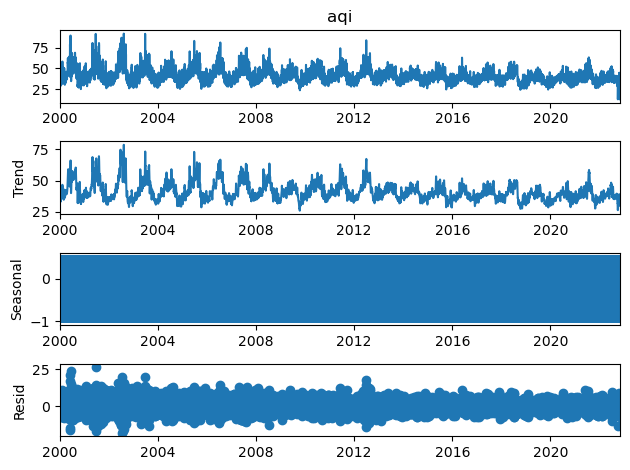

In [21]:
# adopted from class
# Decompose time series into trend, seasonal, and residual components.
decomp =seasonal_decompose(df_daily_all['aqi'])

# Plot the decomposed time series.
decomp.plot();

### Monthly Change in AQI, 2000 - 2022

In [26]:
# resample by month
df_m = df_daily_all.resample('M').mean()

In [27]:
df_m.head()

,aqi
date,
2000-01-31,36.279317
2000-02-29,40.800939
2000-03-31,38.986306
2000-04-30,43.198448
2000-05-31,51.832154


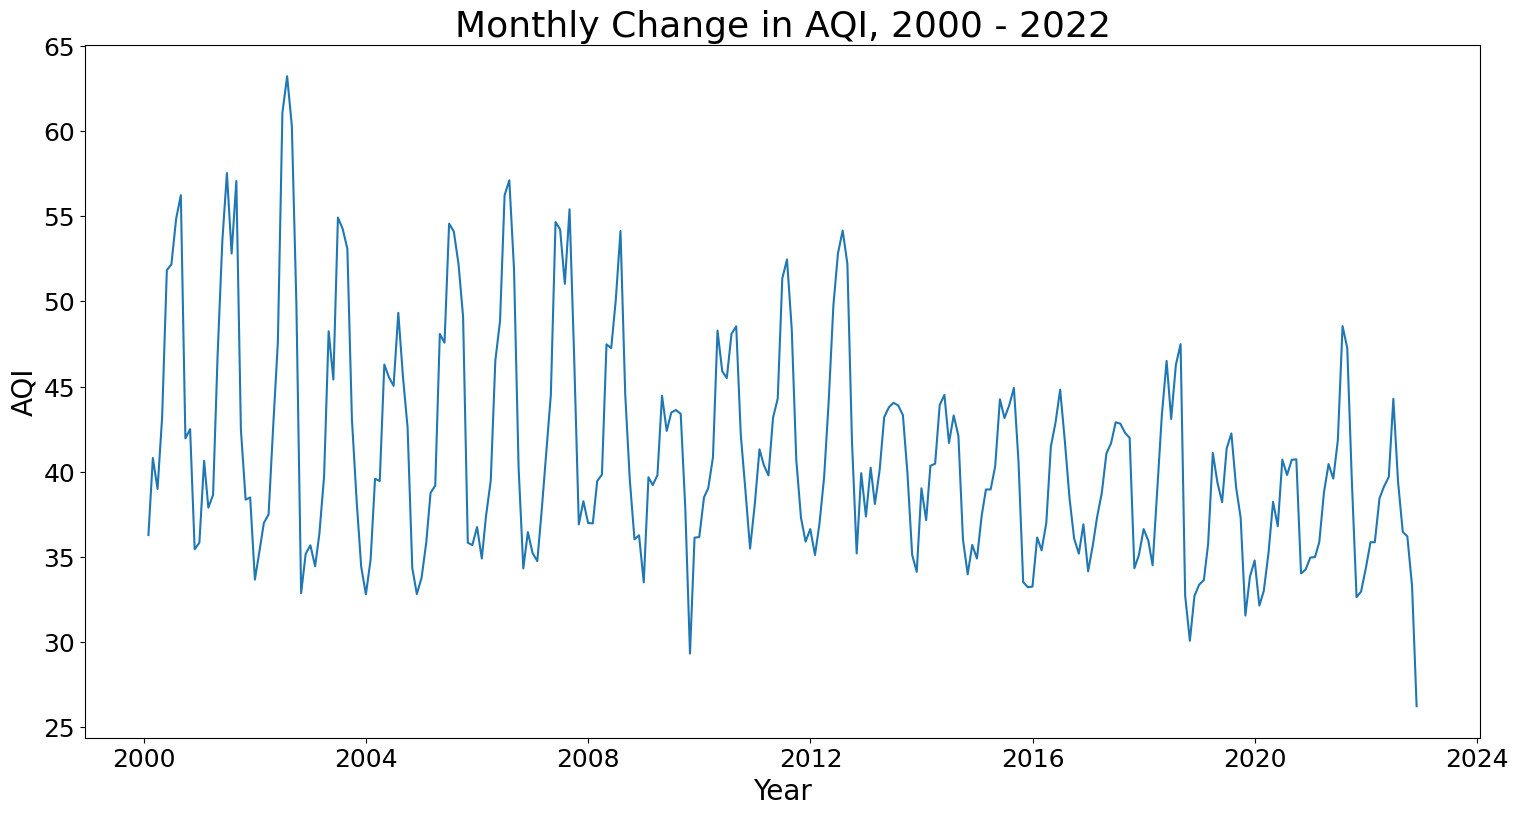

In [28]:
plot_series(df_m, cols=['aqi'], title="Monthly Change in AQI, 2000 - 2022", xlab='Year', ylab = 'AQI')

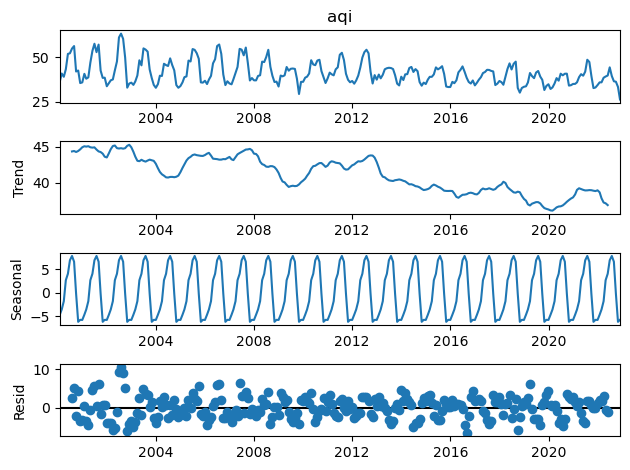

In [29]:
# Decompose time series into trend, seasonal, and residual components.
decomp =seasonal_decompose(df_m['aqi'])

# Plot the decomposed time series.
decomp.plot();

### Weekly Change in AQI, 2000 - 2022

In [29]:
# resample by week
df_w = df_daily_all.resample('W').mean()

In [30]:
df_w.head()

,aqi
date,
2000-01-02,46.294334
2000-01-09,33.216880
2000-01-16,34.257179
2000-01-23,35.589386
2000-01-30,37.251943


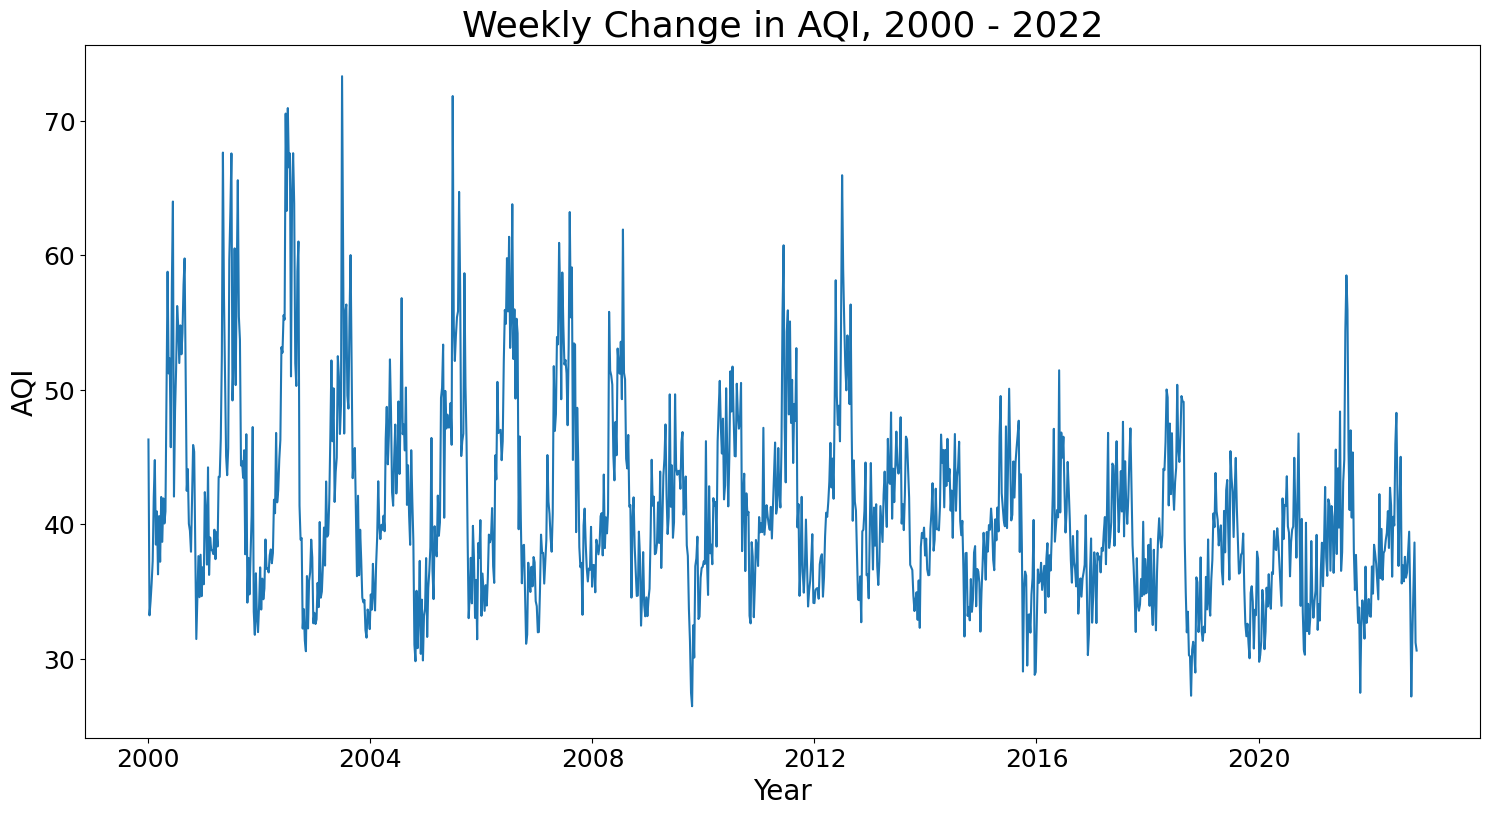

In [31]:
plot_series(df_w, cols=['aqi'], title="Weekly Change in AQI, 2000 - 2022", xlab='Year', ylab = 'AQI')

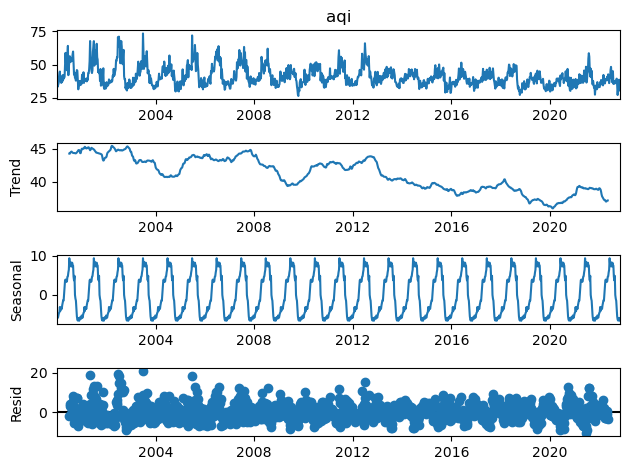

In [32]:
# Decompose time series into trend, seasonal, and residual components.
decomp =seasonal_decompose(df_w['aqi'])

# Plot the decomposed time series.
decomp.plot();

### Daily Change in AQI, 2012 - 2022

In [33]:
df_10_year = df_daily_all.loc['2012-11-02':'2022-11-02']

In [34]:
df_10_year.head()

,aqi
date,
2012-11-02,33.436448
2012-11-03,34.209531
2012-11-04,35.514743
2012-11-05,36.543007
2012-11-06,37.724028


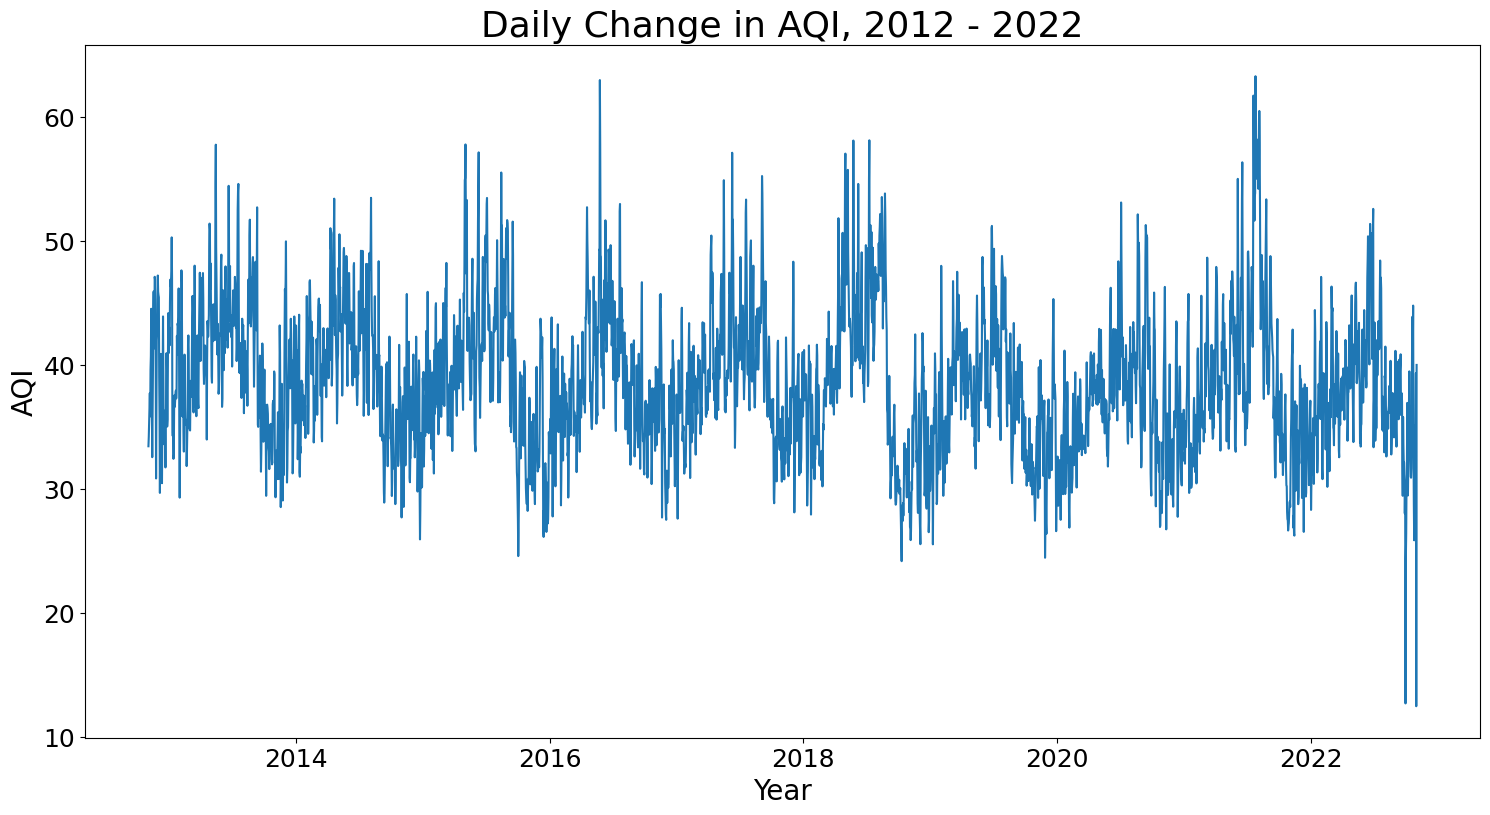

In [35]:
plot_series(df_10_year, cols=['aqi'], title="Daily Change in AQI, 2012 - 2022", xlab='Year', ylab = 'AQI')

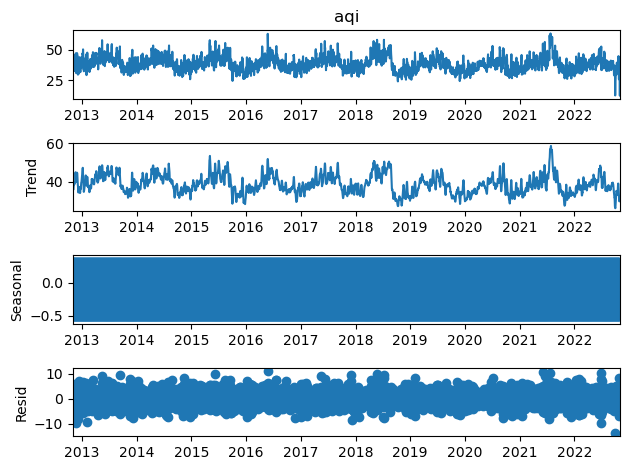

In [36]:
# Decompose time series into trend, seasonal, and residual components.
decomp =seasonal_decompose(df_10_year['aqi'])

# Plot the decomposed time series.
decomp.plot();

### Monthly Change in AQI, 2012 - 2022

In [37]:
# resample by month
df_10_year_m = df_10_year.resample('M').mean()

In [38]:
df_10_year_m.head()

,aqi
date,
2012-11-30,40.150613
2012-12-31,37.370256
2013-01-31,40.232763
2013-02-28,38.104477
2013-03-31,40.090758


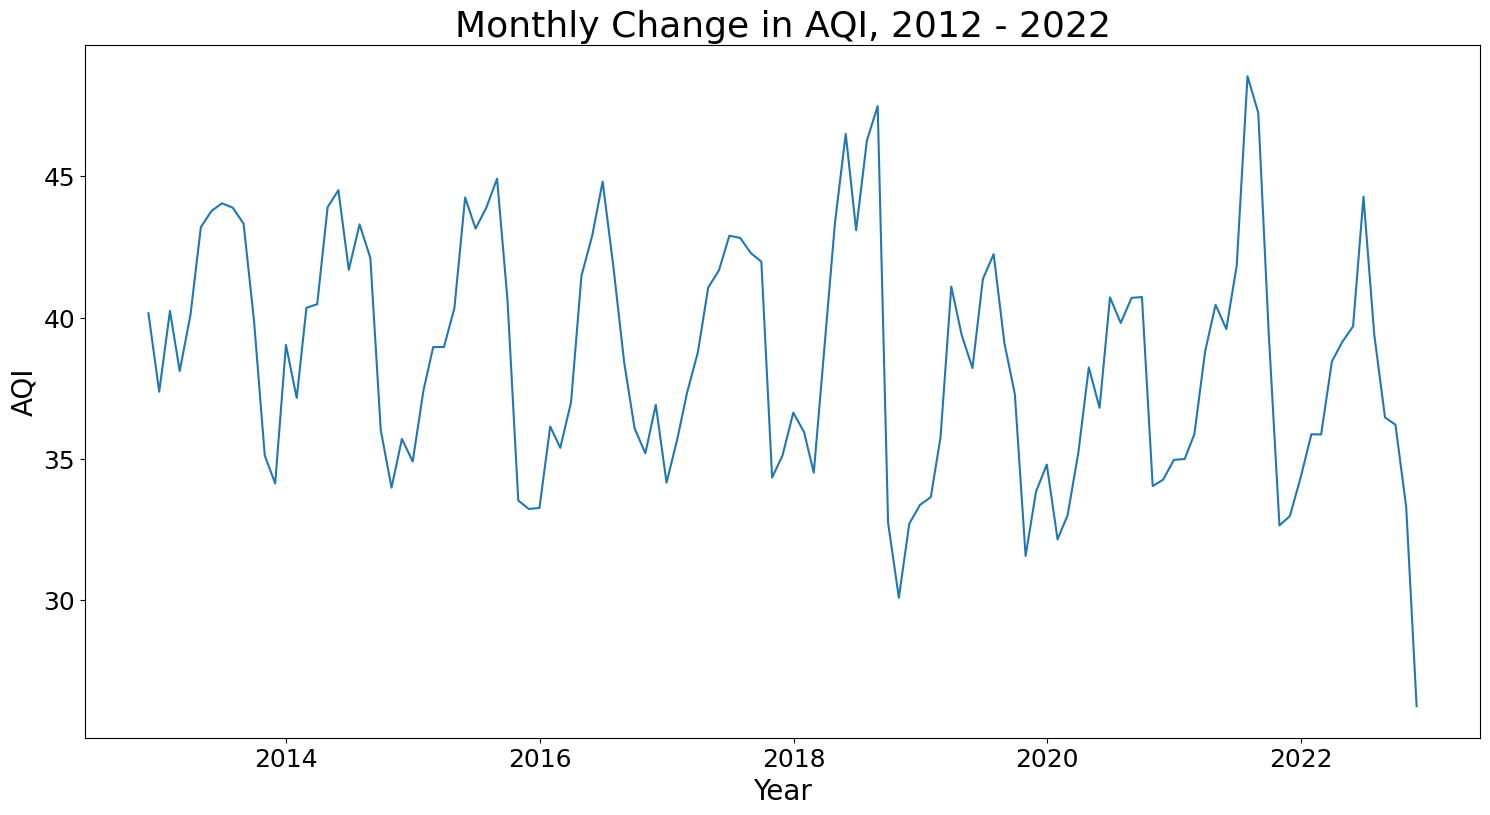

In [39]:
plot_series(df_10_year_m, cols=['aqi'], title="Monthly Change in AQI, 2012 - 2022", xlab='Year', ylab = 'AQI')

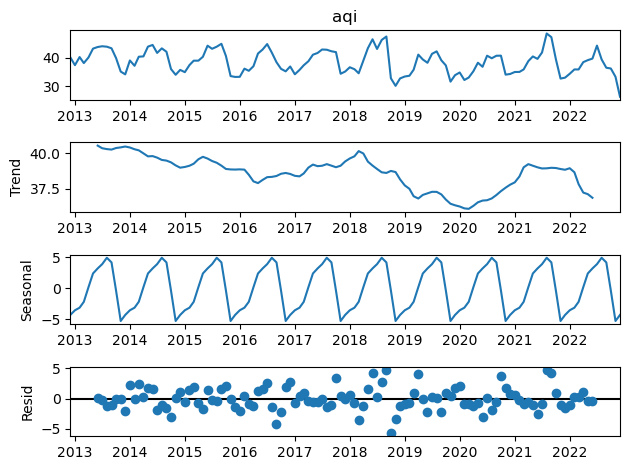

In [40]:
# Decompose time series into trend, seasonal, and residual components.
decomp =seasonal_decompose(df_10_year_m['aqi'])

# Plot the decomposed time series.
decomp.plot();

### Weekly Change in AQI, 2012 - 2022

In [41]:
# resample by week
df_10_year_w = df_10_year.resample('W').mean()

In [42]:
df_10_year_w.head()

,aqi
date,
2012-11-04,34.386907
2012-11-11,39.462404
2012-11-18,39.585609
2012-11-25,40.985412
2012-12-02,44.580652


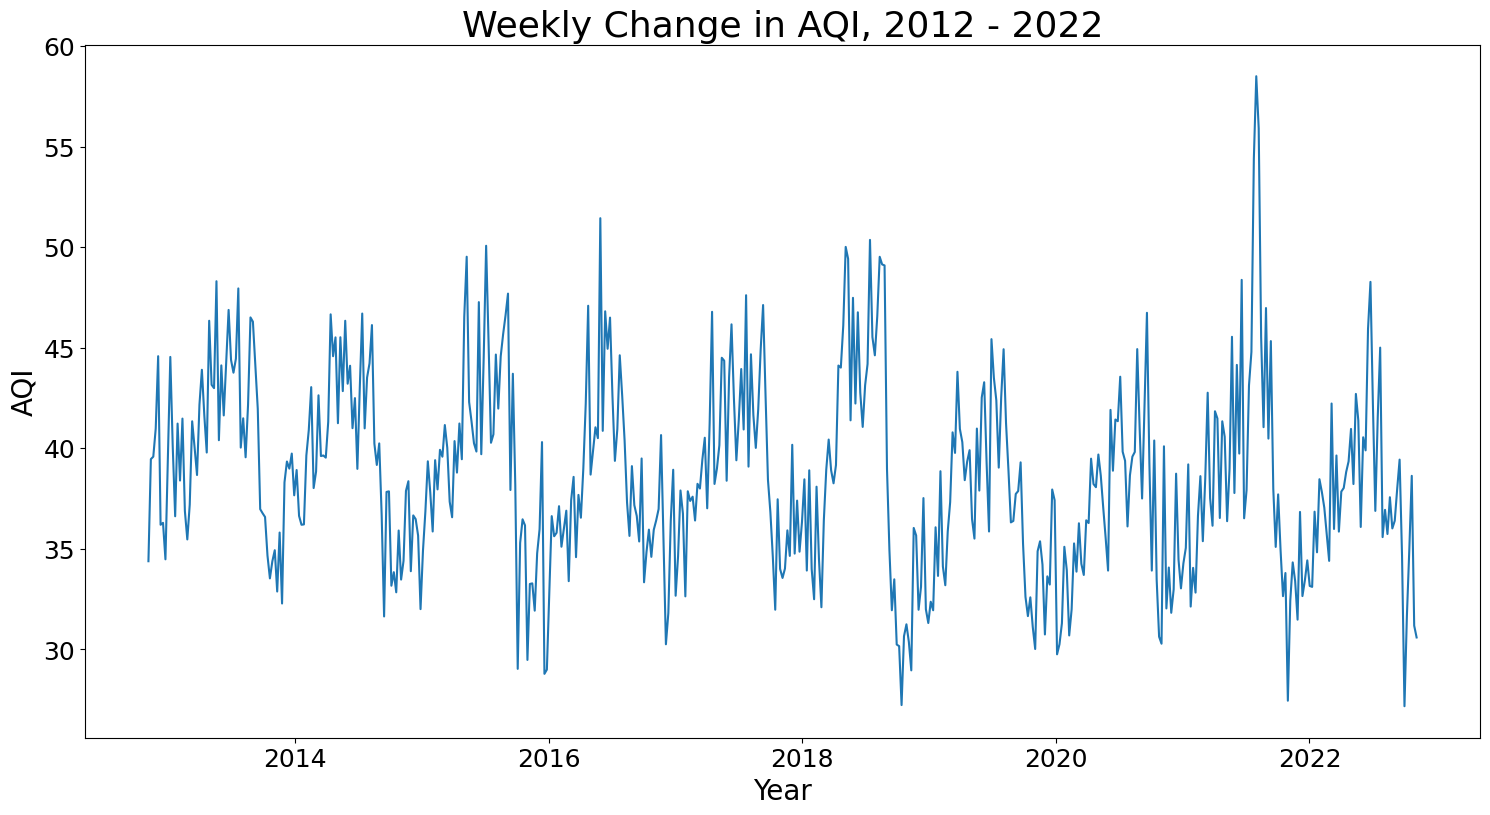

In [43]:
plot_series(df_10_year_w, cols=['aqi'], title="Weekly Change in AQI, 2012 - 2022", xlab='Year', ylab = 'AQI')

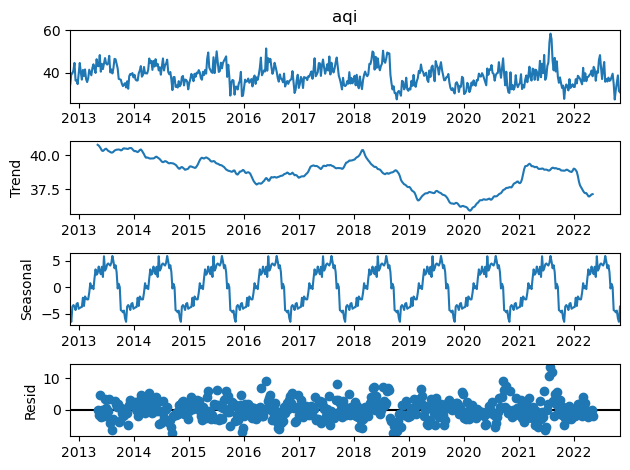

In [44]:
# Decompose time series into trend, seasonal, and residual components.
decomp =seasonal_decompose(df_10_year_w['aqi'])

# Plot the decomposed time series.
decomp.plot();

### Autocorrelation of  Monthly AQI Change 2000-2022

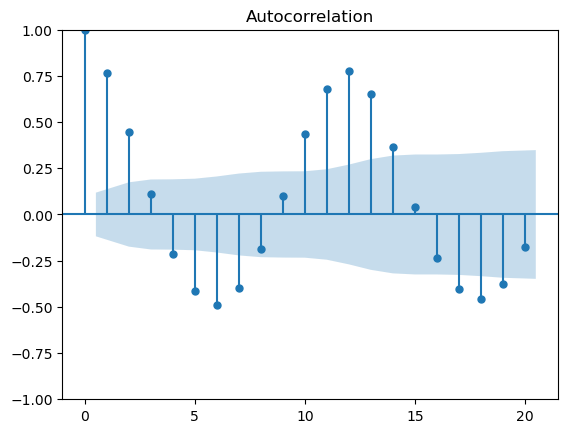

In [30]:
# Generate the ACF plot on AQI data

plot_acf(df_m['aqi'], lags = 20);

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


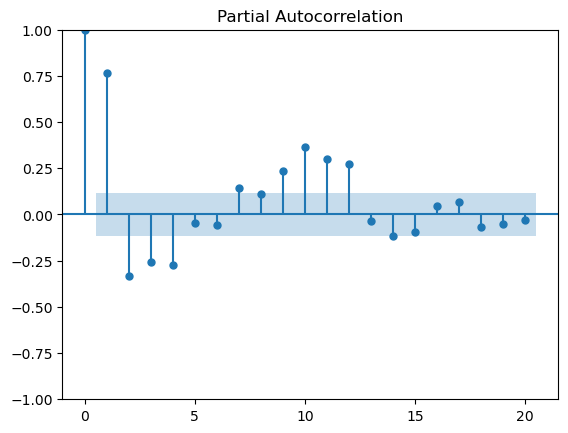

In [31]:
# Generate the PACF plot on AQI data

plot_pacf(df_m['aqi'], lags = 20);

#### Take away:
1. Based on the time plot, there is a trend. Overall, the trend is descreasing.
2. Based on the time plot, there is evidence of seasonality. There appear to be peaks around the summer time about every twelve months. This makes sense, more outdoor activities(traveling by car or plane) and increased usage of air conditioning. 
3. Based on the ACF plot, there is a trend. the coefficient is high at lag 1, 12, 13 and low at lag 6, 7, 8, 17, 18, 19. In terms of the month, high positive correlations for January, November, December, whereas April to August have negative correlations.
4. Based on the ACF and PACF plots, there is evidence of seasonality. In the ACF plot, there is a "scalloped" shape visually and the ACF values peak and bottom roughly every 12 months. In the PACF plot, there are some seasonal fluctuations suggesting by positive and some negative significant partial autocorrelations.

In [32]:
# Generate a dataframe with AQI data 
# adopted from class

# lags AQI by one month
df_m['aqi_lag_1'] = df_m['aqi'].shift(1)
# lags AQI by two month
df_m['aqi_lag_2'] = df_m['aqi'].shift(2)
# lags AQI by one year
df_m['aqi_seasonal'] = df_m['aqi'].shift(12)


In [33]:
# Calculate the correlations among these columns.
df_m.corr()

,aqi,aqi_lag_1,aqi_lag_2,aqi_seasonal
aqi,1.000000,0.772205,0.453723,0.821665
aqi_lag_1,0.772205,1.000000,0.771507,0.715019
aqi_lag_2,0.453723,0.771507,1.000000,0.451364
aqi_seasonal,0.821665,0.715019,0.451364,1.000000


In [34]:
# Create a variable called `time` that takes on a value of 0 in for begining of the data 2000-01-31,
# then increases by 1 each month until the end of the dataframe.
df_m['time'] = range(0, df_m.shape[0])

In [35]:
df_m.head(), df_m.tail()

(                  aqi  aqi_lag_1  aqi_lag_2  aqi_seasonal  time
 date                                                           
 2000-01-31  36.279317        NaN        NaN           NaN     0
 2000-02-29  40.800939  36.279317        NaN           NaN     1
 2000-03-31  38.986306  40.800939  36.279317           NaN     2
 2000-04-30  43.198448  38.986306  40.800939           NaN     3
 2000-05-31  51.832154  43.198448  38.986306           NaN     4,
                   aqi  aqi_lag_1  aqi_lag_2  aqi_seasonal  time
 date                                                           
 2022-07-31  39.393454  44.277896  39.689090     48.548626   270
 2022-08-31  36.459889  39.393454  44.277896     47.256036   271
 2022-09-30  36.202572  36.459889  39.393454     39.475228   272
 2022-10-31  33.286323  36.202572  36.459889     32.634459   273
 2022-11-30  26.229167  33.286323  36.202572     32.966351   274)

### Linear model

In [36]:
# Generate train/test split.
X_train, X_test, y_train, y_test = train_test_split(df_m.drop(columns='aqi'),
                                                    df_m['aqi'],
                                                    test_size = 0.2, shuffle=False)

In [37]:
# Check shape 
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((220, 4), (55, 4), (220,), (55,))

In [38]:
# Fit a linear model
# Import statsmodels.
import statsmodels.api as sm

In [39]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# check
X_train.head()

,const,aqi_lag_1,aqi_lag_2,aqi_seasonal,time
date,,,,,
2000-01-31,1.0,NaN,NaN,NaN,0
2000-02-29,1.0,36.279317,NaN,NaN,1
2000-03-31,1.0,40.800939,36.279317,NaN,2
2000-04-30,1.0,38.986306,40.800939,NaN,3
2000-05-31,1.0,43.198448,38.986306,NaN,4


In [40]:
# dfop null value since statsmodels won't be able to handle missing values.

X_train.dropna(inplace=True)
y_train = y_train[X_train.index]

# This way we subset y_train to keep only indices from X_train.

In [41]:
# instantiate the model
lm = sm.OLS(y_train, X_train)

# fit
lm_results = lm.fit()

In [42]:
print(lm_results.summary())

                            OLS Regression Results                            
Dep. Variable:                    aqi   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     186.1
Date:                Thu, 04 May 2023   Prob (F-statistic):           1.02e-66
Time:                        18:47:42   Log-Likelihood:                -525.70
No. Observations:                 208   AIC:                             1061.
Df Residuals:                     203   BIC:                             1078.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            7.2017      1.847      3.900   

In [43]:
# Generate predicted test values.
lm_results.predict(X_test)

date
2018-05-31    42.701580
2018-06-30    44.067346
2018-07-31    41.221667
2018-08-31    43.674668
2018-09-30    43.435245
2018-10-31    30.596833
2018-11-30    33.141392
2018-12-31    36.107108
2019-01-31    35.490480
2019-02-28    34.757001
2019-03-31    38.179551
2019-04-30    42.971519
2019-05-31    42.190432
2019-06-30    40.223019
2019-07-31    43.961195
2019-08-31    44.290688
2019-09-30    34.804546
2019-10-31    33.203153
2019-11-30    31.591275
2019-12-31    34.707980
2020-01-31    34.827903
2020-02-29    34.084320
2020-03-31    37.929431
2020-04-30    38.156080
2020-05-31    38.775774
2020-06-30    38.754605
2020-07-31    41.853621
2020-08-31    38.749204
2020-09-30    38.590374
2020-10-31    35.506431
2020-11-30    32.692732
2020-12-31    34.987139
2021-01-31    34.010299
2021-02-28    34.276763
2021-03-31    35.898140
2021-04-30    38.904286
2021-05-31    38.416909
2021-06-30    39.452250
2021-07-31    40.536418
2021-08-31    44.354812
2021-09-30    41.917188
2021-10-31 

In [44]:
# Import R2 score and MSE.
from sklearn.metrics import r2_score, mean_squared_error

In [45]:
print(f'R2 Score: {r2_score(y_test, lm_results.predict(X_test))}')
print(f'RMSE: {mean_squared_error(y_test, lm_results.predict(X_test)) ** 0.5}')
print(f'Mean AQI: {y_test.mean()}')

R2 Score: 0.5396414323076083
RMSE: 3.150620268531487
Mean AQI: 37.68400268476834


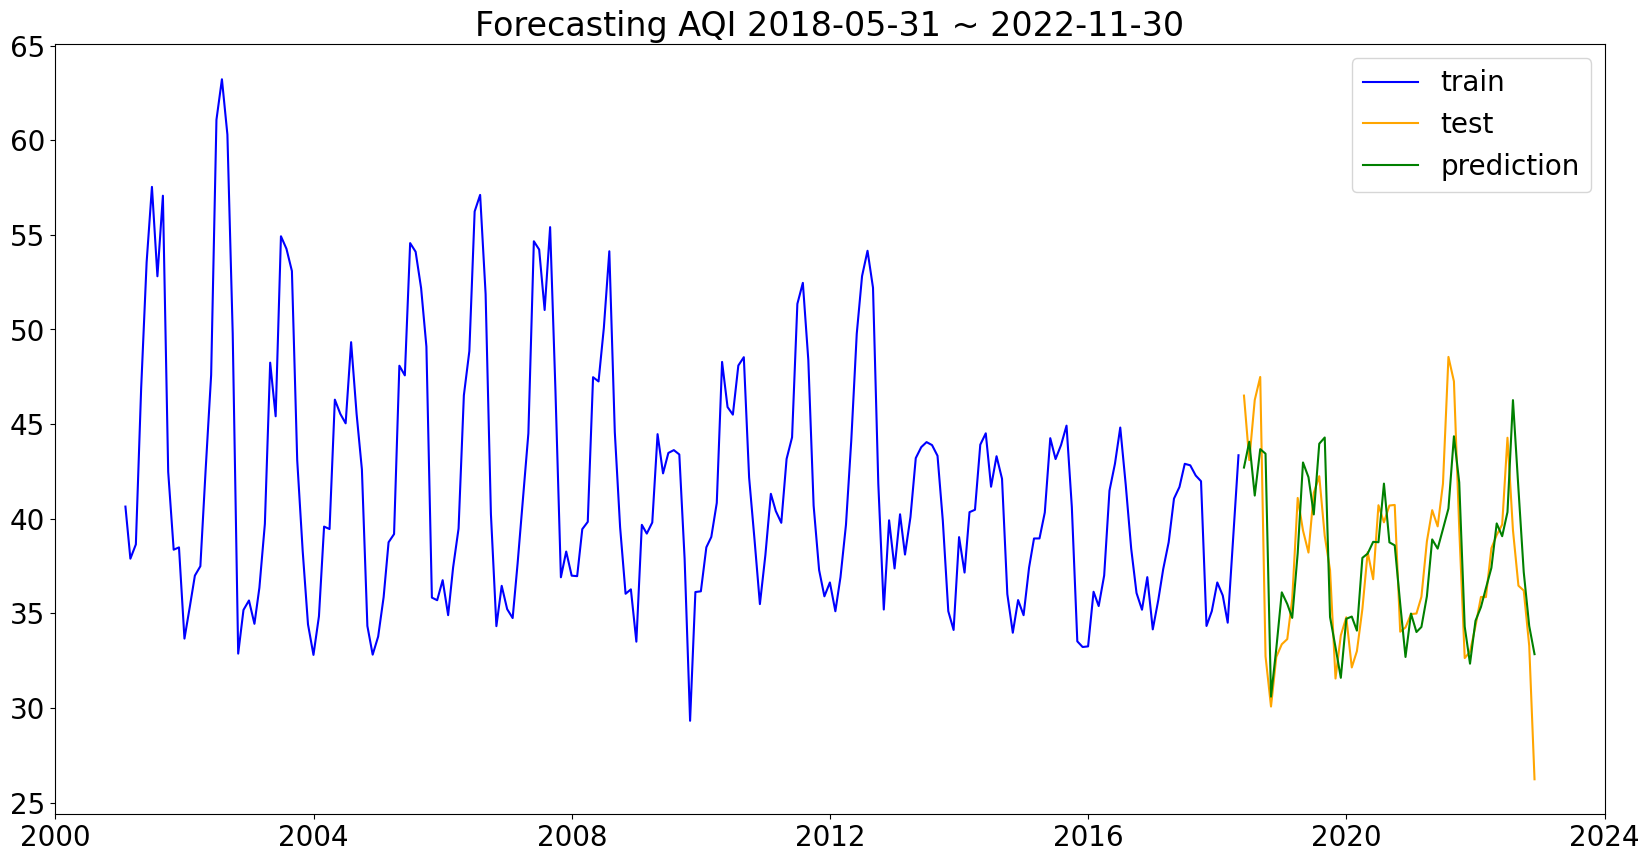

In [46]:
# plot the  predictions; adopted from class

# Set figure size.
plt.figure(figsize=(20,10))

# Plot training data.
plt.plot(y_train.index, y_train.values, color = 'blue', label = 'train')

# Plot testing data.
plt.plot(y_test.index, y_test.values, color = 'orange', label = 'test')

# Plot predicted test values.
plt.plot(lm_results.predict(X_test), color = 'green', label = 'prediction')

# Set label.
plt.title(label = 'Forecasting AQI 2018-05-31 ~ 2022-11-30', fontsize=24)

# Resize tick marks.
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20);

### SARIMA(Seasonal Autoregressive Integrated Moving Average) Model

In [170]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# https://pypi.org/project/pmdarima/
#!pip install pmdarima
from pmdarima import auto_arima

In [171]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split

In [187]:
# read data
df = pd.read_csv('../output/air_quality_by_county_daily.csv')

# Change date column to be datetime dtype
df['date'] = pd.to_datetime(df['date'])

# groupby 'state' and 'date' to get avg AQI by state
df_daily_state = df.groupby(['state_name', 'date'])['aqi'].mean().reset_index()

# groupby date' to get avg AQI by date
df_daily_all = df_daily_state.groupby(['date'])['aqi'].mean().reset_index()

# Set the index to be date
df_daily_all.set_index('date', inplace=True)

# resample by month
df_m = df_daily_all.resample('M').mean()

In [173]:
df_m.head()

,aqi
date,
2000-01-31,36.279317
2000-02-29,40.800939
2000-03-31,38.986306
2000-04-30,43.198448
2000-05-31,51.832154


In [174]:
df_m.tail()

,aqi
date,
2022-07-31,39.393454
2022-08-31,36.459889
2022-09-30,36.202572
2022-10-31,33.286323
2022-11-30,26.229167


In [175]:
# run auto arima to find the best parameter
auto_arima(y=df_m['aqi'],start_p=0,start_P=0,start_q=0,start_Q=0,seasonal=True, m=12).summary()

# the best model is: SARIMAX(3, 1, 4)x(1, 0, [1], 12)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  275
Model:             SARIMAX(3, 1, 4)x(1, 0, [1], 12)   Log Likelihood                -668.979
Date:                              Thu, 04 May 2023   AIC                           1357.957
Time:                                      23:16:33   BIC                           1394.088
Sample:                                  01-31-2000   HQIC                          1372.459
                                       - 11-30-2022                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0413      0.065     15.947      0.000       0.913       1.169
ar.L2         -0.0033      0.059     -0.056      0.956      -0.119       0.112
ar.L3         -0.4801      0.060     -8.046      0.000      -0.597      -0.363
ma.L1         -1.5388      0.072    -21.320      0.000      -1.680      -1.397
ma.L2          0.2435      0.046      5.271      0.000       0.153       0.334
ma.L3          0.8171      0.125      6.541      0.000       0.572       1.062
ma.L4         -0.5036      0.090     -5.625      0.000      -0.679      -0.328
ar.S.L12       0.9895      0.008    123.646      0.000       0.974       1.005
ma.S.L12      -0.8636      0.057    -15.252      0.000      -0.975      -0.753
sigma2         7.2302      0.579     12.484      0.000       6.095       8.365
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                22.43
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                            -0.32
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [176]:
len(df_m)

275

In [177]:
#split data into train and test:
train = df_m[:220]
test = df_m[220:]

In [178]:
# Fit SARIMA model with the best parameter: (3, 1, 4)x(1, 0, [1], 12)
sarima = SARIMAX(train.astype(float).dropna() , order = (3, 1, 4), seasonal_order = (1, 0, 1, 12))

# Fit SARIMA model.
model = sarima.fit()

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [179]:
print(model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                  aqi   No. Observations:                  220
Model:             SARIMAX(3, 1, 4)x(1, 0, [1], 12)   Log Likelihood                -537.333
Date:                              Thu, 04 May 2023   AIC                           1094.667
Time:                                      23:18:15   BIC                           1128.558
Sample:                                  01-31-2000   HQIC                          1108.354
                                       - 04-30-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0638      0.247      4.307      0.000       0.580       1.548
ar.L2          0.05

In [180]:
# obtain predicted values
predictions = model.predict(start=220, end=274, typ='levels').rename('Predictions')

In [181]:
# obtain forecasted values
future_forecasts = model.predict(start=274, end=333, typ='levels').rename('future_forecasts')

In [182]:
train.shape, test.shape, predictions.shape

((220, 1), (55, 1), (55,))

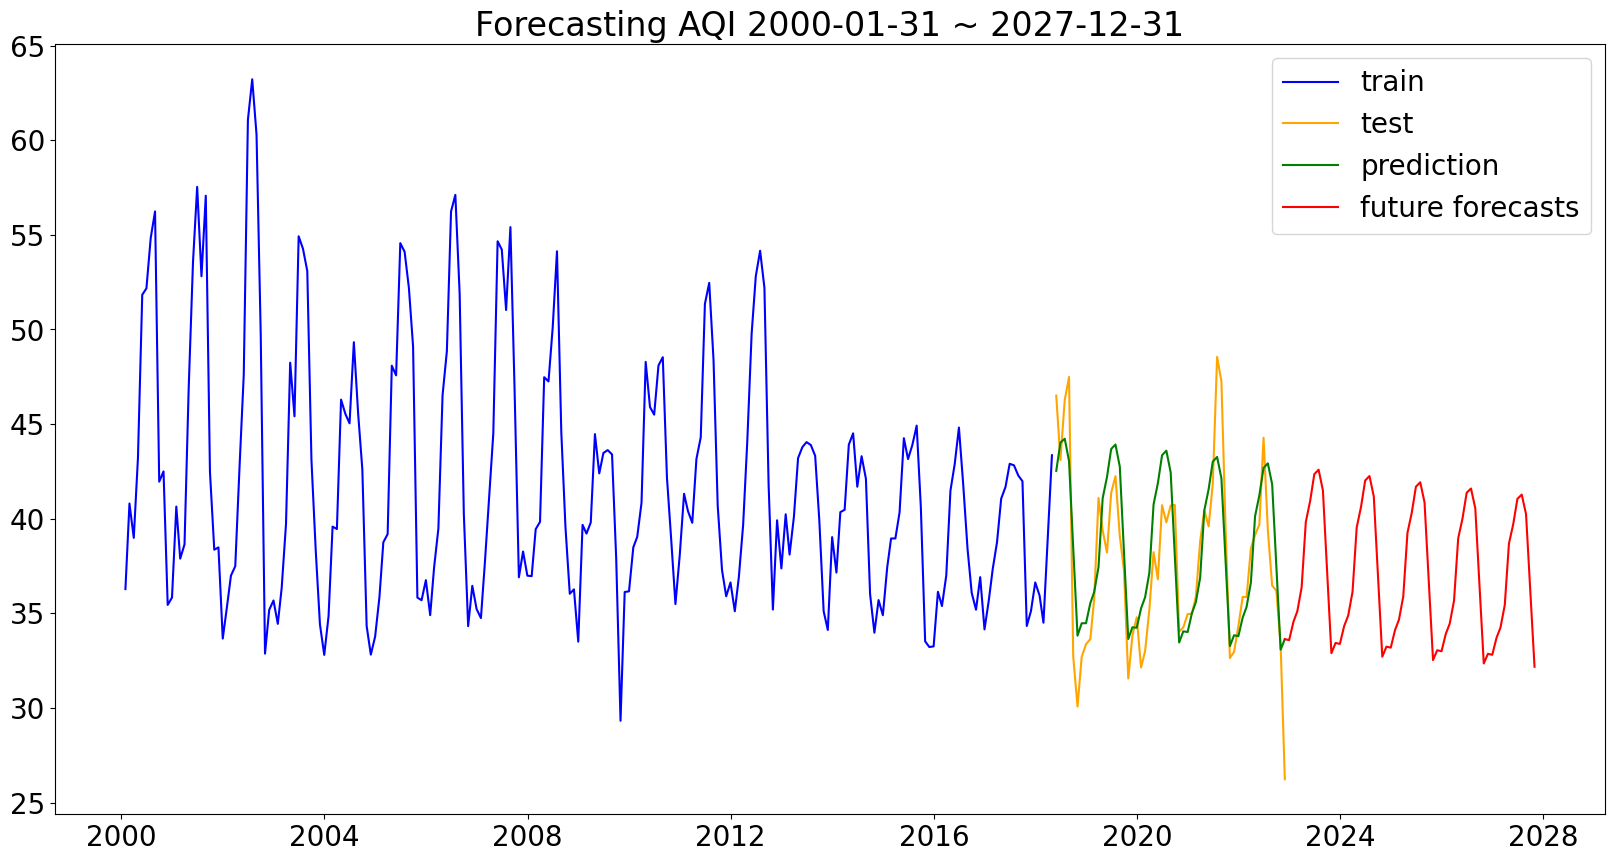

In [184]:
# plot predictions ad future forecasts

# Set figure size.
plt.figure(figsize=(20,10))

# Plot training data.
plt.plot(train.index, train.values, color = 'blue', label = 'train')

# Plot testing data.
plt.plot(test.index, test.values, color = 'orange', label = 'test')

# Plot predicted test values.
plt.plot(predictions, color = 'green', label = 'prediction')

# Plot predicted test values.
plt.plot(future_forecasts, color = 'red', label = 'future forecasts')

# Set label.
plt.title(label = 'Forecasting AQI 2000-01-31 ~ 2027-12-31', fontsize=24)

# Resize tick marks.
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20);

In [185]:
print(f'R2 Score: {r2_score(test, predictions).round(2)}')
print(f'RMSE: {np.sqrt(mean_squared_error(test, predictions)).round(2)}')
print(f'Mean AQI: {test.mean().round(2)}')

R2 Score: 0.65
RMSE: 2.76
Mean AQI: aqi    37.68
dtype: float64


In [188]:
# Look at the first 5 values
df_m['aqi'][:5]

date
2000-01-31    36.279317
2000-02-29    40.800939
2000-03-31    38.986306
2000-04-30    43.198448
2000-05-31    51.832154
Freq: M, Name: aqi, dtype: float64

In [189]:
# Look at the first 5 values of our original series, differenced once.
df_m['aqi'].diff(1)[:5]

date
2000-01-31         NaN
2000-02-29    4.521622
2000-03-31   -1.814633
2000-04-30    4.212142
2000-05-31    8.633706
Freq: M, Name: aqi, dtype: float64

In [190]:
# Look at the first 5 values of our original series, differenced twice.
df_m['aqi'].diff(1).diff(1)[:5]

date
2000-01-31         NaN
2000-02-29         NaN
2000-03-31   -6.336255
2000-04-30    6.026775
2000-05-31    4.421564
Freq: M, Name: aqi, dtype: float64

In [191]:
# Create first_diff_aqi and second_diff_aqi
df_m['first_diff_aqi'] = df_m['aqi'].diff(1)
df_m['second_diff_aqi'] = df_m['aqi'].diff(1).diff(1)

In [192]:
df_m.head()

,aqi,first_diff_aqi,second_diff_aqi
date,,,
2000-01-31,36.279317,NaN,NaN
2000-02-29,40.800939,4.521622,NaN
2000-03-31,38.986306,-1.814633,-6.336255
2000-04-30,43.198448,4.212142,6.026775
2000-05-31,51.832154,8.633706,4.421564


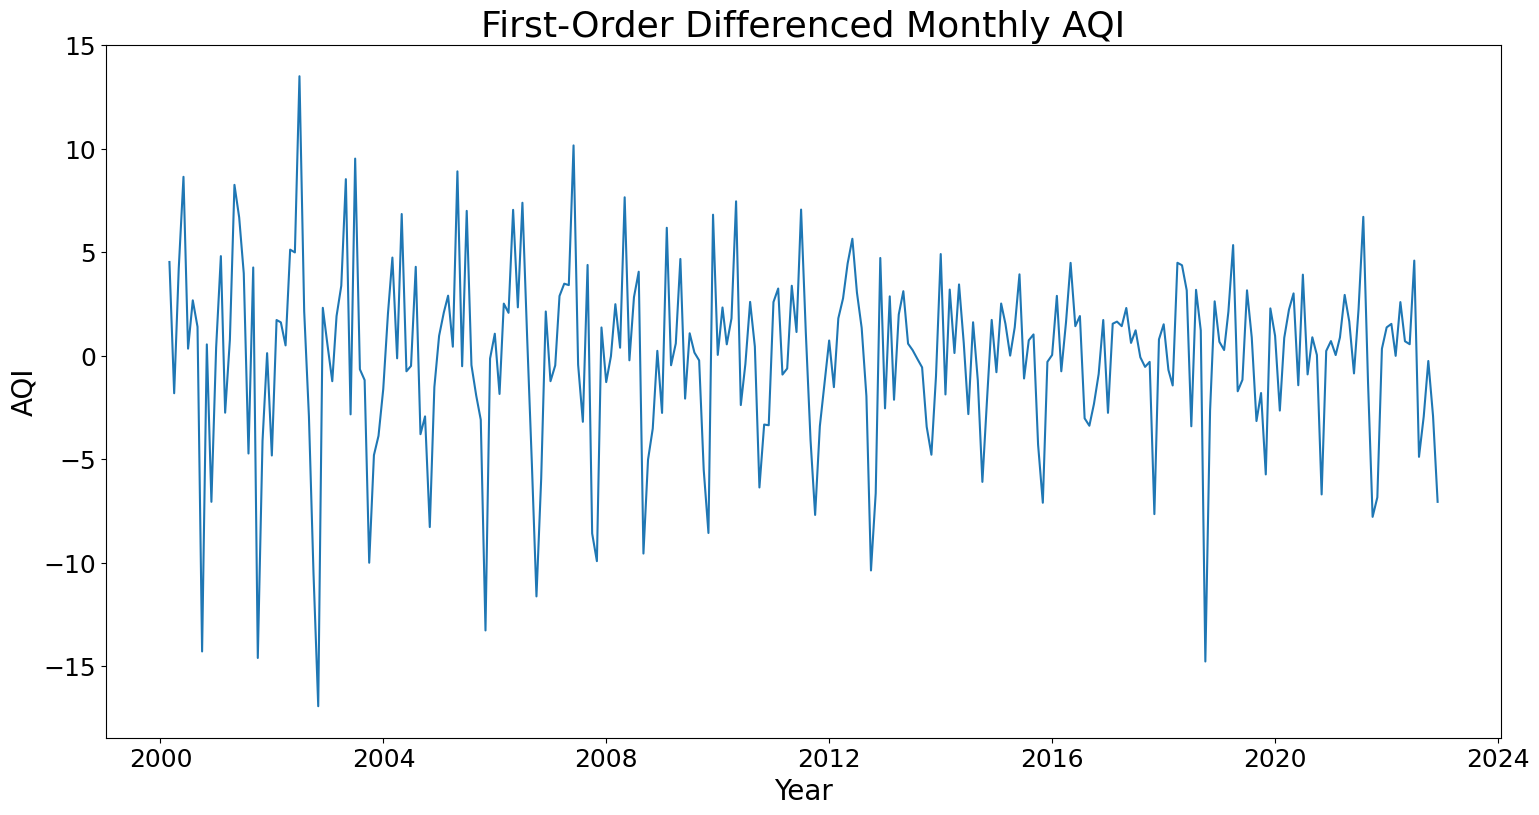

In [193]:
# plot differenced once data
plot_series(df_m, cols=['first_diff_aqi'], title = "First-Order Differenced Monthly AQI", xlab='Year', ylab = 'AQI', 
            steps=18)

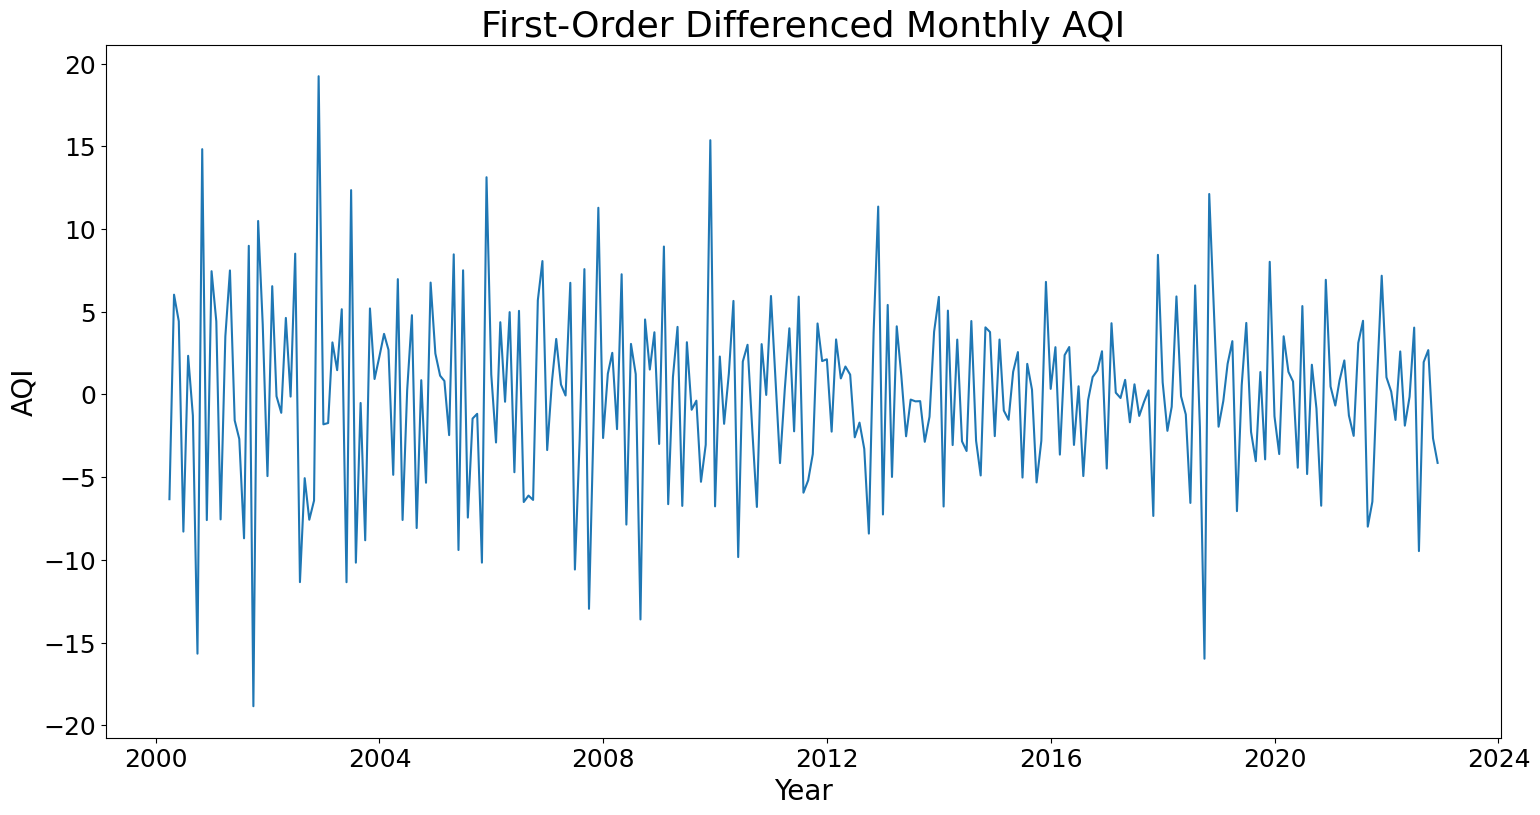

In [194]:
# plot differenced twice data
plot_series(df_m, cols=['second_diff_aqi'], title = "First-Order Differenced Monthly AQI", xlab='Year', ylab = 'AQI', 
            steps=18)

In [195]:
# Checking for Stationarity: the Augmented Dickey-Fuller Test
# Import Augmented Dickey-Fuller test.
from statsmodels.tsa.stattools import adfuller

In [196]:
# Run ADF test on original (non-differenced!) data.
adfuller(df_m['aqi'])

(-1.307620044598123,
 0.6256789632850923,
 14,
 260,
 {'1%': -3.4557539868570775,
  '5%': -2.8727214497041422,
  '10%': -2.572728476331361},
 1296.9225748932756)

In [197]:
# adopted from class
# Code written by Joseph Nelson.

def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [198]:
# Run ADF test on original (non-differenced!) data.
interpret_dftest(adfuller(df_m['aqi']))

# p-value > 0.05, not stationarity

Test Statistic   -1.307620
p-value           0.625679
dtype: float64

In [199]:
# Run the ADF test on once-differenced data.

interpret_dftest(adfuller(df_m['first_diff_aqi'].dropna()))

Test Statistic   -1.467899e+01
p-value           3.178192e-27
dtype: float64

In [200]:
# Run the ADF test on twice-differenced data.

interpret_dftest(adfuller(df_m['second_diff_aqi'].dropna()))

Test Statistic   -9.364728e+00
p-value           7.654515e-16
dtype: float64

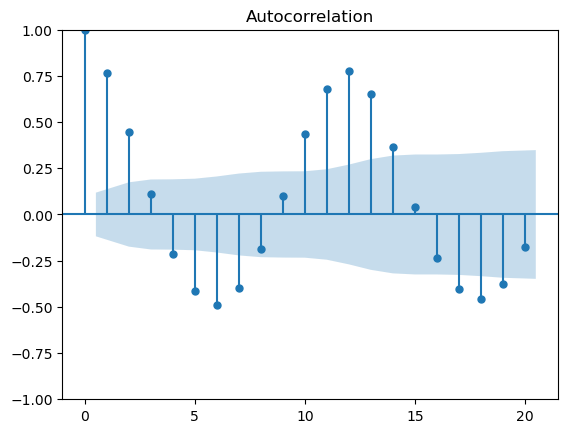

In [204]:
# Generate plot for original (non-differenced!) data.
plot_acf(df_m['aqi'].dropna(), lags=20);

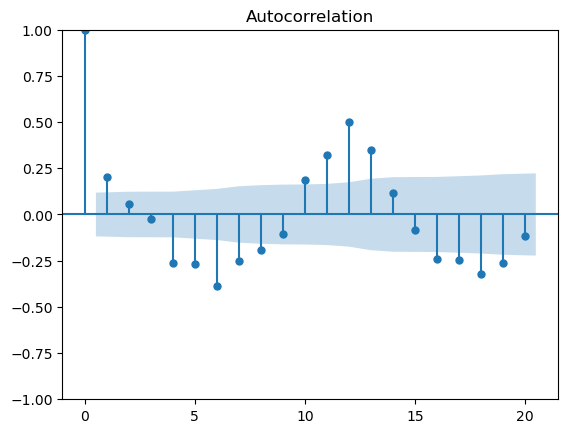

In [202]:
# Generate plot for once-differenced data.
plot_acf(df_m['first_diff_aqi'].dropna(), lags=20);

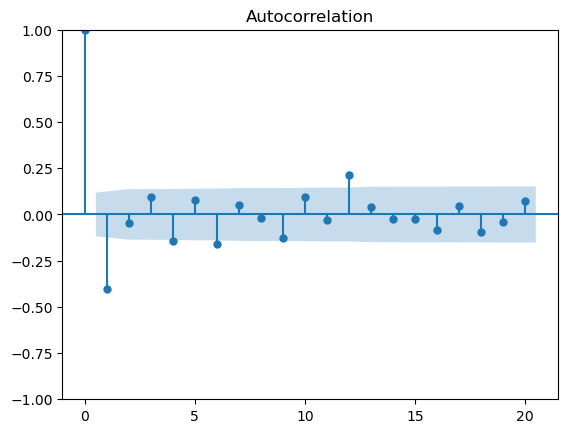

In [203]:
# Generate plot for twice-differenced data.
plot_acf(df_m['second_diff_aqi'].dropna(), lags=20);

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


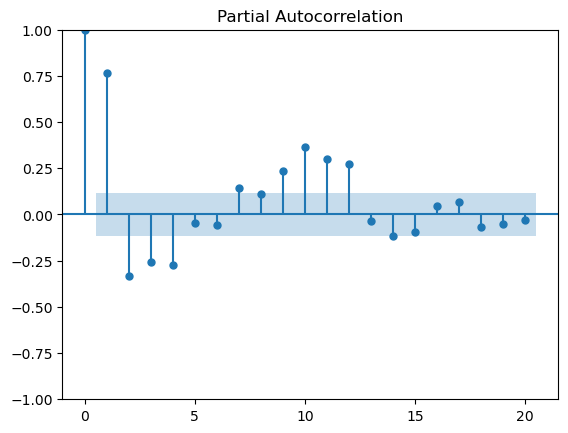

In [205]:
# Generate plot for original (non-differenced!) data.
plot_pacf(df_m['aqi'].dropna(), lags=20);

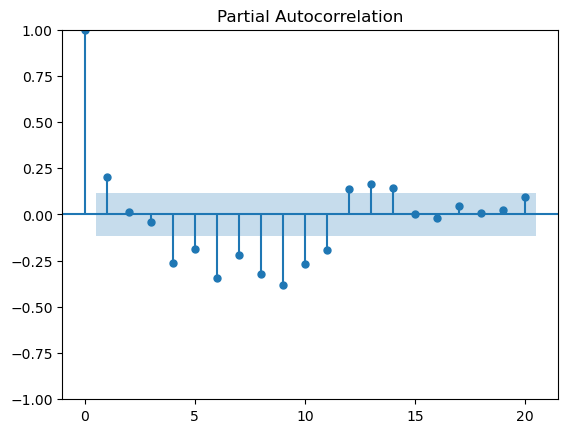

In [206]:
# Generate plot for once-differenced data.
plot_pacf(df_m['first_diff_aqi'].dropna(), lags=20);

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


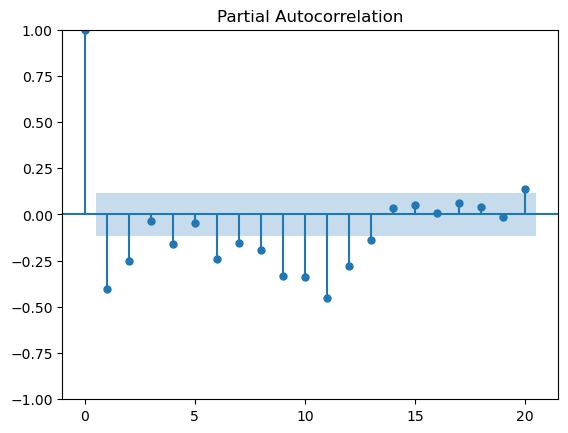

In [85]:
# Generate plot for twice-differenced data..
plot_pacf(df_m['second_diff_aqi'].dropna(), lags=20);

#### Take away:
The predicted values are fairly close to our actual values using SARIMA with RMSE score of 2.77. Using this model to forcasts AQI value for 2023 and 2024 seems promising. Originally, we planned to use EV car registration as an external variable; however, we don't have the monthly data forEV car registration. 

### California

In [77]:
df_daily_state.head()

,state_name,date,aqi
0,Alabama,2000-01-01,48.150000
1,Alabama,2000-01-02,39.333333
2,Alabama,2000-01-03,46.333333
3,Alabama,2000-01-04,30.076923
4,Alabama,2000-01-05,33.666667


In [78]:
# how much is the average amount of pollution in each city stations
most_polluted = df_daily_state[['state_name', 'aqi']].groupby(['state_name']).mean().sort_values(by = 'aqi', ascending = False)
most_polluted

,aqi
state_name,
California,57.621844
District Of Columbia,55.401018
Arizona,51.381220
Delaware,50.792675
Utah,49.920359
Maryland,46.688139
Pennsylvania,45.457283
Georgia,45.169821
Connecticut,45.015936


In [79]:
aqi_california = df_daily_state[df_daily_state['state_name'] == 'California']

In [80]:
aqi_california.head()

,state_name,date,aqi
33199,California,2000-01-01,70.884615
33200,California,2000-01-02,34.666667
33201,California,2000-01-03,41.395833
33202,California,2000-01-04,54.280000
33203,California,2000-01-05,39.058824


In [81]:
aqi_california = aqi_california.drop(['state_name'], axis=1)

In [82]:
# Set the index to be date
aqi_california.set_index('date', inplace=True)

# resample by month
aqi_california_m = aqi_california.resample('M').mean()

In [83]:
aqi_california_m.head()

,aqi
date,
2000-01-31,45.646582
2000-02-29,40.529576
2000-03-31,56.293504
2000-04-30,56.210960
2000-05-31,69.020344


In [84]:
# run auto arima to find the best parameter
auto_arima(y=aqi_california_m['aqi'],start_p=0,start_P=0,start_q=0,start_Q=0,seasonal=True, m=12).summary()

# the best model is: SARIMAX(5, 1, 1)x(1, 0, [1], 12)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  274
Model:             SARIMAX(5, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -942.653
Date:                            Thu, 04 May 2023   AIC                           1903.306
Time:                                    17:04:45   BIC                           1935.791
Sample:                                01-31-2000   HQIC                          1916.346
                                     - 10-31-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4339      0.061      7.125      0.000       0.315       0.553
ar.L2         -0.1160      0.065     -1.792      0.073      -0.243       0.011
ar.L3          0.0578      0.066      0.875      0.382      -0.072       0.187
ar.L4         -0.0387      0.033     -1.159      0.246      -0.104       0.027
ar.L5         -0.1059      0.076     -1.396      0.163      -0.255       0.043
ma.L1         -0.9854      0.035    -28.020      0.000      -1.054      -0.916
ar.S.L12       0.9863      0.012     85.212      0.000       0.964       1.009
ma.S.L12      -0.8774      0.051    -17.056      0.000      -0.978      -0.777
sigma2        55.2580      3.652     15.129      0.000      48.100      62.416
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               231.31
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               1.56   Skew:                             1.17
Prob(H) (two-sided):                  0.03   Kurtosis:                         6.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [85]:
len(aqi_california_m)

274

In [86]:
#split data into train and test:
train = aqi_california_m[:220]
test = aqi_california_m[220:]

In [87]:
# Fit SARIMA model with the best parameter: (5, 1, 1)x(1, 0, [1], 12)
sarima = SARIMAX(train.astype(float).dropna() , order = (5, 1, 1), seasonal_order = (1, 0, 1, 12))

# Fit SARIMA model.
model = sarima.fit()

In [88]:
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                aqi   No. Observations:                  220
Model:             SARIMAX(5, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -731.505
Date:                            Thu, 04 May 2023   AIC                           1481.010
Time:                                    17:04:48   BIC                           1511.512
Sample:                                01-31-2000   HQIC                          1493.329
                                     - 04-30-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3030      0.072      4.195      0.000       0.161       0.445
ar.L2         -0.0577      0.076   

In [89]:
# obtain predicted values
predictions = model.predict(start=220, end=273, typ='levels').rename('Predictions')

In [90]:
# obtain forecasted values
future_forecasts = model.predict(start=273, end=333, typ='levels').rename('future_forecasts')

In [91]:
train.shape, test.shape, predictions.shape

((220, 1), (54, 1), (54,))

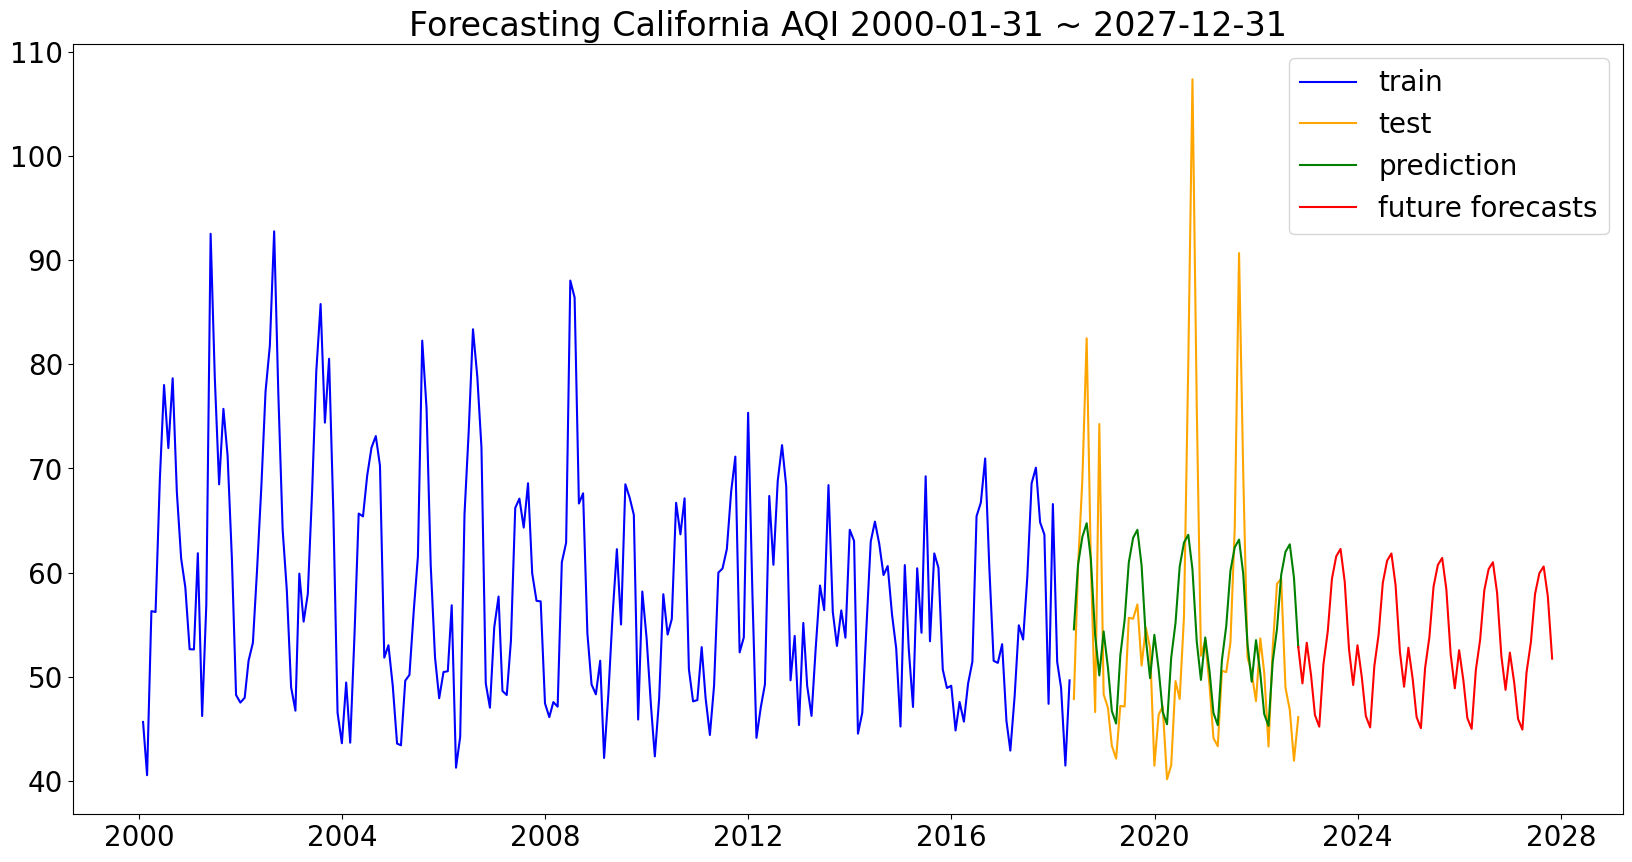

In [92]:
# plot predictions ad future forecasts

# Set figure size.
plt.figure(figsize=(20,10))

# Plot training data.
plt.plot(train.index, train.values, color = 'blue', label = 'train')

# Plot testing data.
plt.plot(test.index, test.values, color = 'orange', label = 'test')

# Plot predicted test values.
plt.plot(predictions, color = 'green', label = 'prediction')

# Plot predicted test values.
plt.plot(future_forecasts, color = 'red', label = 'future forecasts')

# Set label.
plt.title(label = 'Forecasting California AQI 2000-01-31 ~ 2027-12-31', fontsize=24)

# Resize tick marks.
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20);

In [93]:
print(f'R2 Score: {r2_score(test, predictions)}')
print(f'RMSE: {np.sqrt(mean_squared_error(test, predictions))}')
print(f'Mean AQI: {test.mean()}')

R2 Score: 0.2639290109303113
RMSE: 11.223312029980253
Mean AQI: aqi    54.619714
dtype: float64


### Maryland

In [94]:
aqi_maryland = df_daily_state[df_daily_state['state_name'] == 'Maryland']

In [95]:
aqi_maryland.head()

,state_name,date,aqi
165782,Maryland,2000-01-01,65.7
165783,Maryland,2000-01-02,45.8
165784,Maryland,2000-01-03,28.8
165785,Maryland,2000-01-04,33.5
165786,Maryland,2000-01-05,31.0


In [96]:
aqi_maryland = aqi_maryland.drop(['state_name'], axis=1)

In [133]:
aqi_maryland.head()

,aqi
date,
2000-01-01,65.7
2000-01-02,45.8
2000-01-03,28.8
2000-01-04,33.5
2000-01-05,31.0


In [97]:
# Set the index to be date
aqi_maryland.set_index('date', inplace=True)

# resample by month
aqi_maryland_m = aqi_maryland.resample('M').mean()

In [98]:
aqi_maryland_m

,aqi
date,
2000-01-31,35.422939
2000-02-29,43.640120
2000-03-31,42.760753
2000-04-30,42.352592
2000-05-31,75.831053
...,...
2022-06-30,49.637639
2022-07-31,44.873297
2022-08-31,39.732975


In [99]:
# run auto arima to find the best parameter
auto_arima(y=aqi_maryland_m['aqi'],start_p=0,start_P=0,start_q=0,start_Q=0,seasonal=True, m=12).summary()

# the best model is: SARIMAX(1, 1, 1)x(1, 0, [1], 12)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  274
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -910.389
Date:                            Thu, 04 May 2023   AIC                           1830.778
Time:                                    17:07:25   BIC                           1848.825
Sample:                                01-31-2000   HQIC                          1838.023
                                     - 10-31-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4377      0.051      8.544      0.000       0.337       0.538
ma.L1         -0.9871      0.015    -64.556      0.000      -1.017      -0.957
ar.S.L12       0.9805      0.009    112.418      0.000       0.963       0.998
ma.S.L12      -0.7378      0.059    -12.575      0.000      -0.853      -0.623
sigma2        43.0767      2.312     18.633      0.000      38.545      47.608
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               189.99
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               0.34   Skew:                            -0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [100]:
len(aqi_maryland_m)

274

In [101]:
#split data into train and test:
train = aqi_maryland_m[:220]
test = aqi_maryland_m[220:273]

In [102]:
# Fit SARIMA model with the best parameter: (1, 1, 1)x(1, 0, [1], 12)
sarima = SARIMAX(train.astype(float).dropna() , order = (1, 1, 1), seasonal_order = (1, 0, 1, 12))

# Fit SARIMA model.
model = sarima.fit()

In [103]:
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                aqi   No. Observations:                  220
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -742.183
Date:                            Thu, 04 May 2023   AIC                           1494.366
Time:                                    17:07:26   BIC                           1511.312
Sample:                                01-31-2000   HQIC                          1501.210
                                     - 04-30-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4380      0.053      8.199      0.000       0.333       0.543
ma.L1         -0.9908      0.015   

In [104]:
# obtain predicted values
predictions = model.predict(start=220, end=272, typ='levels').rename('Predictions')

In [105]:
# obtain forecasted values
future_forecasts = model.predict(start=273, end=333, typ='levels').rename('future_forecasts')

In [106]:
train.shape, test.shape, predictions.shape

((220, 1), (53, 1), (53,))

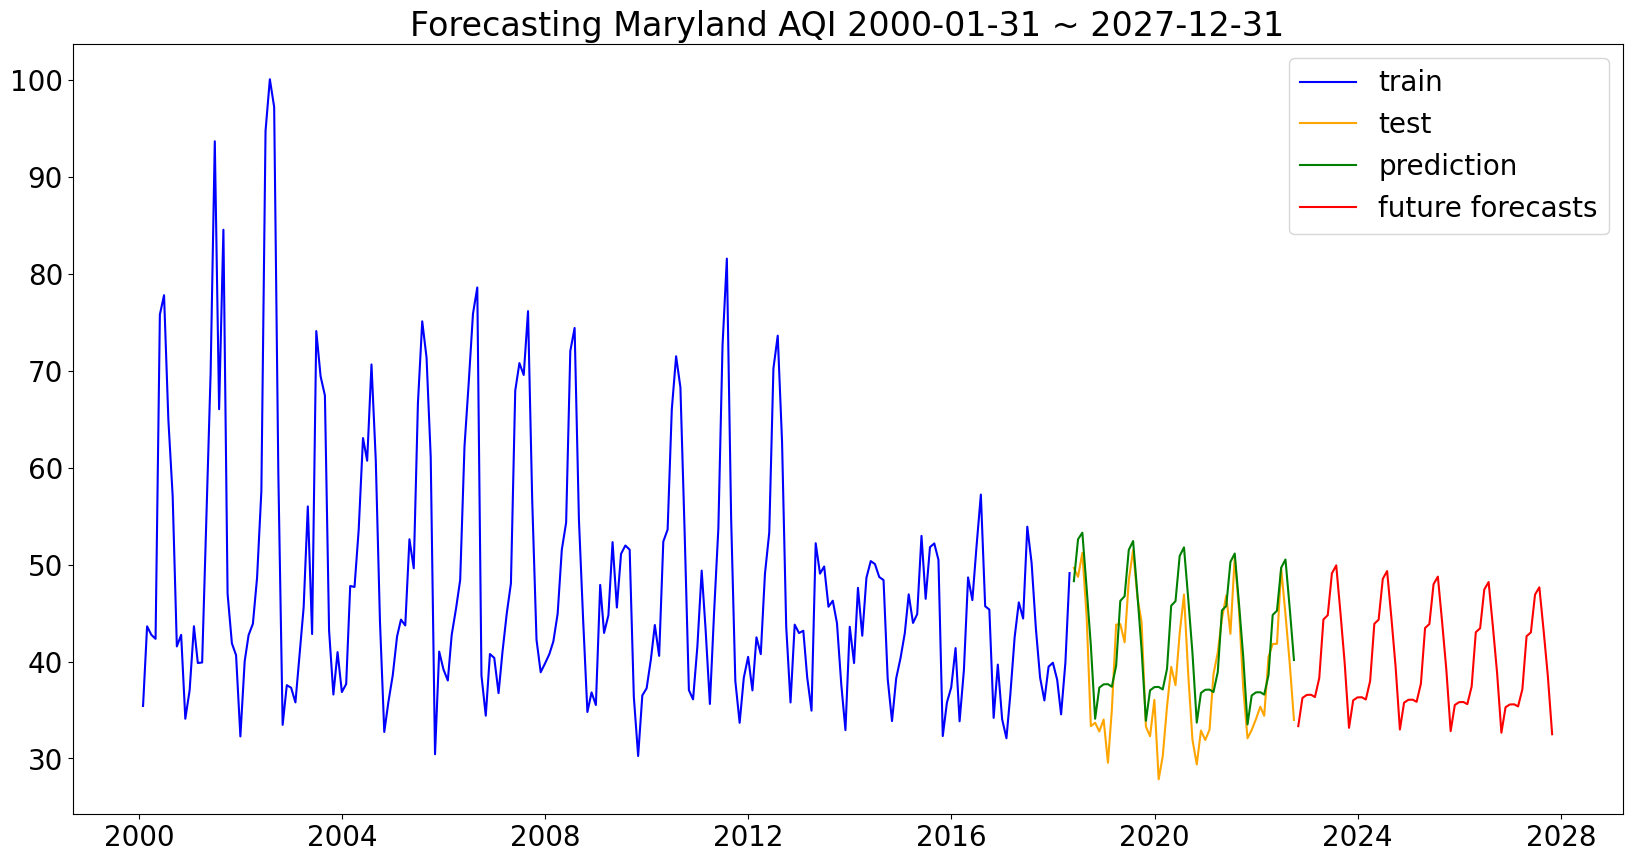

In [107]:
# plot predictions ad future forecasts

# Set figure size.
plt.figure(figsize=(20,10))

# Plot training data.
plt.plot(train.index, train.values, color = 'blue', label = 'train')

# Plot testing data.
plt.plot(test.index, test.values, color = 'orange', label = 'test')

# Plot predicted test values.
plt.plot(predictions, color = 'green', label = 'prediction')

# Plot predicted test values.
plt.plot(future_forecasts, color = 'red', label = 'future forecasts')

# Set label.
plt.title(label = 'Forecasting Maryland AQI 2000-01-31 ~ 2027-12-31', fontsize=24)

# Resize tick marks.
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20);

In [108]:
print(f'R2 Score: {r2_score(test, predictions)}')
print(f'RMSE: {np.sqrt(mean_squared_error(test, predictions))}')
print(f'Mean AQI: {test.mean()}')

R2 Score: 0.5153619001885951
RMSE: 4.559250044544119
Mean AQI: aqi    39.263636
dtype: float64


### Arizona

In [109]:
aqi_arizona = df_daily_state[df_daily_state['state_name'] == 'Arizona']

In [110]:
aqi_arizona.head()

,state_name,date,aqi
16551,Arizona,2000-01-01,48.333333
16552,Arizona,2000-01-02,46.000000
16553,Arizona,2000-01-03,54.600000
16554,Arizona,2000-01-04,44.714286
16555,Arizona,2000-01-05,45.833333


In [111]:
aqi_arizona = aqi_arizona.drop(['state_name'], axis=1)

In [112]:
# Set the index to be date
aqi_arizona.set_index('date', inplace=True)

# resample by month
aqi_arizona_m = aqi_arizona.resample('M').mean()

In [113]:
aqi_arizona_m

,aqi
date,
2000-01-31,54.597692
2000-02-29,53.053448
2000-03-31,51.532574
2000-04-30,63.171799
2000-05-31,71.411137
...,...
2022-06-30,56.357692
2022-07-31,47.914599
2022-08-31,39.931555


In [114]:
# run auto arima to find the best parameter
auto_arima(y=aqi_arizona_m['aqi'],start_p=0,start_P=0,start_q=0,start_Q=0,seasonal=True, m=12).summary()

# the best model is: SARIMAX(4, 1, 1)x(1, 0, [1,2], 12)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  274
Model:             SARIMAX(4, 1, 1)x(1, 0, [1, 2], 12)   Log Likelihood                -895.717
Date:                                 Thu, 04 May 2023   AIC                           1811.435
Time:                                         17:09:17   BIC                           1847.530
Sample:                                     01-31-2000   HQIC                          1825.924
                                          - 10-31-2022                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0002      0.000     -0.486      0.627      -0.001       0.001
ar.L1          0.4950      0.058      8.520      0.000       0.381       0.609
ar.L2         -0.0386      0.063     -0.609      0.542      -0.163       0.085
ar.L3          0.0645      0.060      1.084      0.278      -0.052       0.181
ar.L4         -0.0040      0.061     -0.066      0.947      -0.124       0.116
ma.L1         -0.9828      0.022    -44.217      0.000      -1.026      -0.939
ar.S.L12       0.9898      0.012     79.551      0.000       0.965       1.014
ma.S.L12      -0.7620      0.072    -10.520      0.000      -0.904      -0.620
ma.S.L24      -0.1080      0.068     -1.591      0.112      -0.241       0.025
sigma2        37.3063      2.885     12.931      0.000      31.652      42.961
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                25.18
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.82   Skew:                             0.62
Prob(H) (two-sided):                  0.34   Kurtosis:                         3.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [115]:
len(aqi_arizona_m)

274

In [116]:
#split data into train and test:
train = aqi_arizona_m[:220]
test = aqi_arizona_m[220:]

In [117]:
# Fit SARIMA model with the best parameter: (1, 1, 1)x(1, 0, [1], 12)
sarima = SARIMAX(train.astype(float).dropna() , order = (4, 1, 1), seasonal_order = (1, 0, [1,2], 12))

# Fit SARIMA model.
model = sarima.fit()

In [118]:
print(model.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                     aqi   No. Observations:                  220
Model:             SARIMAX(4, 1, 1)x(1, 0, [1, 2], 12)   Log Likelihood                -715.090
Date:                                 Thu, 04 May 2023   AIC                           1448.179
Time:                                         17:09:21   BIC                           1478.681
Sample:                                     01-31-2000   HQIC                          1460.498
                                          - 04-30-2018                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5032      0.064      7.912      0.000       0.379       0

In [119]:
# obtain predicted values
predictions = model.predict(start=220, end=273, typ='levels').rename('Predictions')

In [120]:
# obtain forecasted values
future_forecasts = model.predict(start=273, end=333, typ='levels').rename('future_forecasts')

In [121]:
train.shape, test.shape, predictions.shape

((220, 1), (54, 1), (54,))

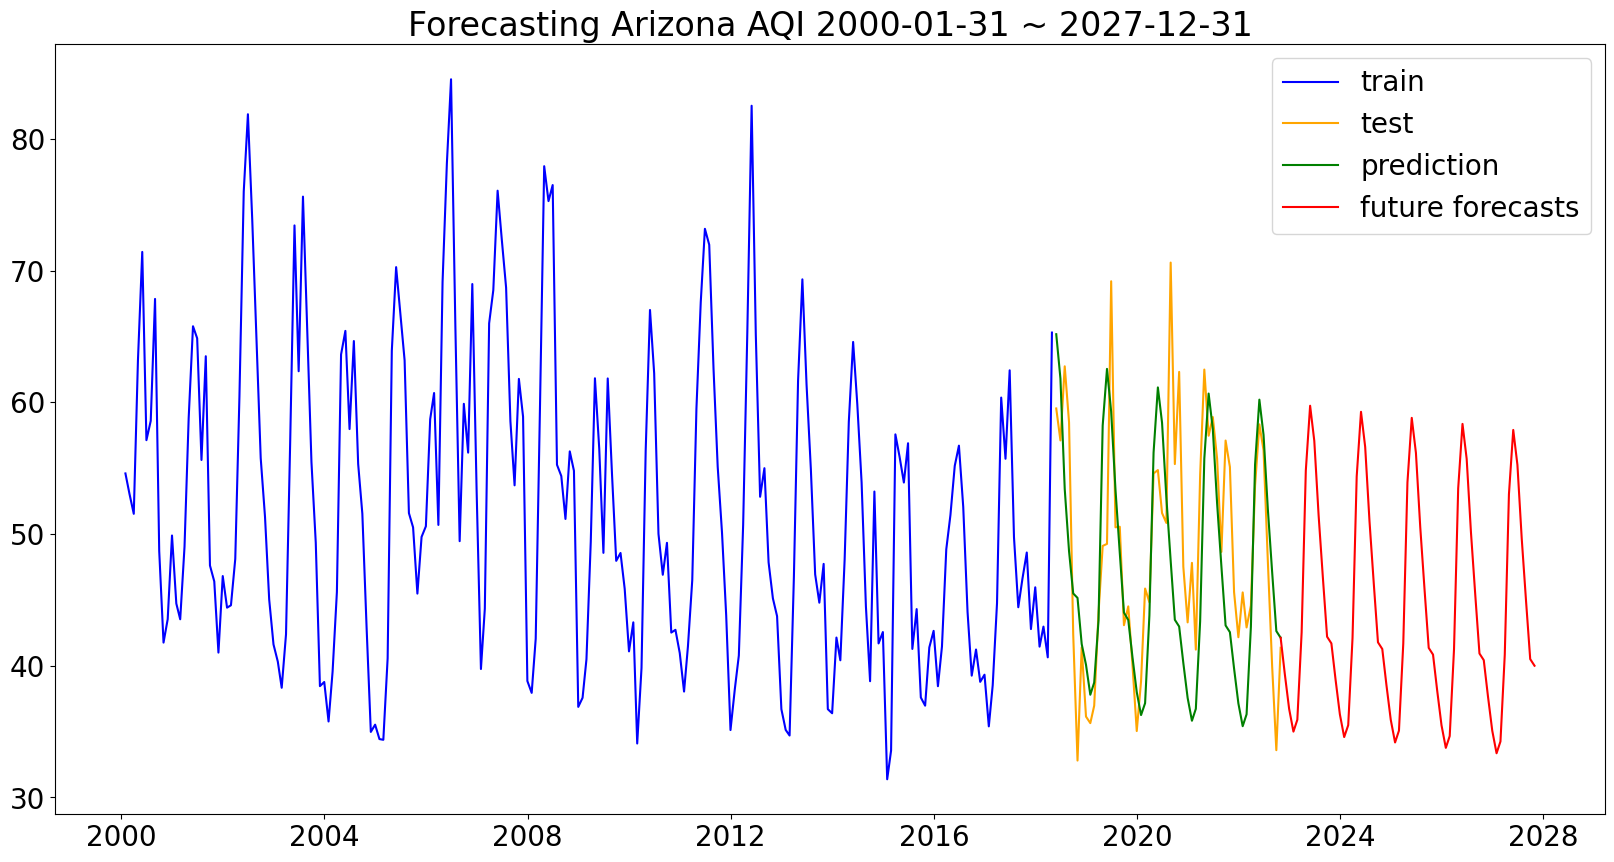

In [122]:
# plot predictions ad future forecasts

# Set figure size.
plt.figure(figsize=(20,10))

# Plot training data.
plt.plot(train.index, train.values, color = 'blue', label = 'train')

# Plot testing data.
plt.plot(test.index, test.values, color = 'orange', label = 'test')

# Plot predicted test values.
plt.plot(predictions, color = 'green', label = 'prediction')

# Plot predicted test values.
plt.plot(future_forecasts, color = 'red', label = 'future forecasts')

# Set label.
plt.title(label = 'Forecasting Arizona AQI 2000-01-31 ~ 2027-12-31', fontsize=24)

# Resize tick marks.
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20);

In [123]:
print(f'R2 Score: {r2_score(test, predictions)}')
print(f'RMSE: {np.sqrt(mean_squared_error(test, predictions))}')
print(f'Mean AQI: {test.mean()}')

R2 Score: 0.2562977474285688
RMSE: 7.657614014239181
Mean AQI: aqi    49.0697
dtype: float64


### New Mexico

In [124]:
aqi_newMexico = df_daily_state[df_daily_state['state_name'] == 'New Mexico']

In [125]:
aqi_newMexico.head()

,state_name,date,aqi
256744,New Mexico,2000-01-01,43.166667
256745,New Mexico,2000-01-02,32.666667
256746,New Mexico,2000-01-03,32.000000
256747,New Mexico,2000-01-04,35.300000
256748,New Mexico,2000-01-05,31.909091


In [126]:
aqi_newMexico = aqi_newMexico.drop(['state_name'], axis=1)

In [127]:
# Set the index to be date
aqi_newMexico.set_index('date', inplace=True)

# resample by month
aqi_newMexico_m = aqi_newMexico.resample('M').mean()

In [128]:
aqi_newMexico_m

,aqi
date,
2000-01-31,35.861393
2000-02-29,38.883918
2000-03-31,39.820938
2000-04-30,45.618965
2000-05-31,53.510010
...,...
2022-05-31,56.339589
2022-06-30,52.139394
2022-07-31,69.666820


In [129]:
# run auto arima to find the best parameter
auto_arima(y=aqi_newMexico_m['aqi'],start_p=0,start_P=0,start_q=0,start_Q=0,seasonal=True, m=12).summary()

# the best model is: SARIMAX(1, 0, 0)x(1, 0, 1, 12)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  273
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                -782.366
Date:                              Thu, 04 May 2023   AIC                           1574.733
Time:                                      17:09:43   BIC                           1592.780
Sample:                                  01-31-2000   HQIC                          1581.977
                                       - 09-30-2022                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2813      0.195      1.445      0.148      -0.100       0.663
ar.L1          0.5346      0.046     11.508      0.000       0.444       0.626
ar.S.L12       0.9856      0.010     99.087      0.000       0.966       1.005
ma.S.L12      -0.8322      0.057    -14.523      0.000      -0.944      -0.720
sigma2        16.4391      1.048     15.690      0.000      14.386      18.493
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                43.95
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               1.02   Skew:                             0.56
Prob(H) (two-sided):                  0.91   Kurtosis:                         4.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [130]:
len(aqi_newMexico_m)

273

In [131]:
#split data into train and test:
train = aqi_newMexico_m[:220]
test = aqi_newMexico_m[220:]

In [132]:
# Fit SARIMA model with the best parameter: (1, 0, 0)x(1, 0, [1], 12)
sarima = SARIMAX(train.astype(float).dropna() , order = (1, 0, 0), seasonal_order = (1, 0, 1, 12))

# Fit SARIMA model.
model = sarima.fit()

In [133]:
print(model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                  aqi   No. Observations:                  220
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                -638.232
Date:                              Thu, 04 May 2023   AIC                           1284.465
Time:                                      17:09:44   BIC                           1298.039
Sample:                                  01-31-2000   HQIC                          1289.947
                                       - 04-30-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5799      0.047     12.266      0.000       0.487       0.673
ar.S.L12       0.99

In [134]:
# obtain predicted values
predictions = model.predict(start=221, end=273, typ='levels').rename('Predictions')

In [135]:
# obtain forecasted values
future_forecasts = model.predict(start=273, end=333, typ='levels').rename('future_forecasts')

In [136]:
train.shape, test.shape, predictions.shape

((220, 1), (53, 1), (53,))

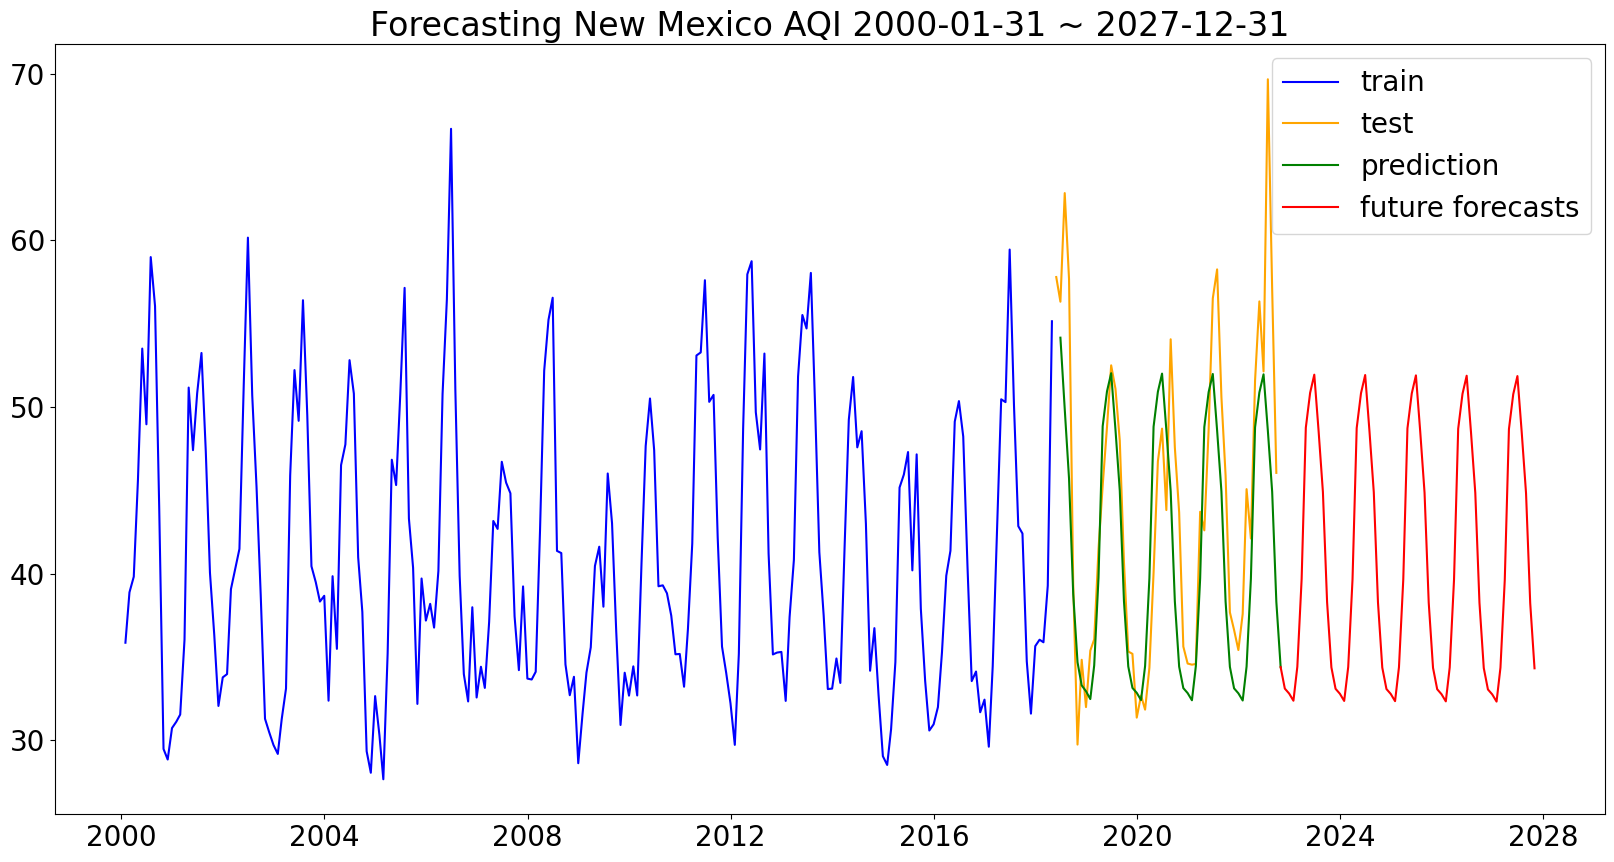

In [137]:
# plot predictions ad future forecasts

# Set figure size.
plt.figure(figsize=(20,10))

# Plot training data.
plt.plot(train.index, train.values, color = 'blue', label = 'train')

# Plot testing data.
plt.plot(test.index, test.values, color = 'orange', label = 'test')

# Plot predicted test values.
plt.plot(predictions, color = 'green', label = 'prediction')

# Plot predicted test values.
plt.plot(future_forecasts, color = 'red', label = 'future forecasts')

# Set label.
plt.title(label = 'Forecasting New Mexico AQI 2000-01-31 ~ 2027-12-31', fontsize=24)

# Resize tick marks.
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20);

In [138]:
print(f'R2 Score: {r2_score(test, predictions)}')
print(f'RMSE: {np.sqrt(mean_squared_error(test, predictions))}')
print(f'Mean AQI: {test.mean()}')

R2 Score: 0.14201168472172943
RMSE: 8.610508826715085
Mean AQI: aqi    44.308611
dtype: float64


### Florida

In [313]:
aqi_florida = df_daily_state[df_daily_state['state_name'] == 'Florida']

In [314]:
aqi_florida.head()

,state_name,date,aqi
74505,Florida,2000-01-01,49.562500
74506,Florida,2000-01-02,38.666667
74507,Florida,2000-01-03,35.280000
74508,Florida,2000-01-04,30.615385
74509,Florida,2000-01-05,32.307692


In [315]:
aqi_florida = aqi_florida.drop(['state_name'], axis=1)

In [316]:
# Set the index to be date
aqi_florida.set_index('date', inplace=True)

# resample by month
aqi_florida_m = aqi_newMexico.resample('M').mean()

In [317]:
aqi_florida_m

,aqi
date,
2000-01-31,35.861393
2000-02-29,38.883918
2000-03-31,39.820938
2000-04-30,45.618965
2000-05-31,53.510010
...,...
2022-05-31,56.339589
2022-06-30,52.139394
2022-07-31,69.666820


In [318]:
# run auto arima to find the best parameter
auto_arima(y=aqi_florida_m['aqi'],start_p=0,start_P=0,start_q=0,start_Q=0,seasonal=True, m=12).summary()

# the best model is: SARIMAX(1, 0, 0)x(1, 0, 1, 12)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  273
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                -782.366
Date:                              Thu, 04 May 2023   AIC                           1574.733
Time:                                      18:19:37   BIC                           1592.780
Sample:                                  01-31-2000   HQIC                          1581.977
                                       - 09-30-2022                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2813      0.195      1.445      0.148      -0.100       0.663
ar.L1          0.5346      0.046     11.508      0.000       0.444       0.626
ar.S.L12       0.9856      0.010     99.087      0.000       0.966       1.005
ma.S.L12      -0.8322      0.057    -14.523      0.000      -0.944      -0.720
sigma2        16.4391      1.048     15.690      0.000      14.386      18.493
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                43.95
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               1.02   Skew:                             0.56
Prob(H) (two-sided):                  0.91   Kurtosis:                         4.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [319]:
len(aqi_florida_m)

273

In [320]:
#split data into train and test:
train = aqi_florida_m[:220]
test = aqi_florida_m[220:]

In [321]:
# Fit SARIMA model with the best parameter: (1, 0, 0)x(1, 0, [1], 12)
sarima = SARIMAX(train.astype(float).dropna() , order = (1, 0, 0), seasonal_order = (1, 0, 1, 12))

# Fit SARIMA model.
model = sarima.fit()

In [322]:
print(model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                  aqi   No. Observations:                  220
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                -638.232
Date:                              Thu, 04 May 2023   AIC                           1284.465
Time:                                      18:19:57   BIC                           1298.039
Sample:                                  01-31-2000   HQIC                          1289.947
                                       - 04-30-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5799      0.047     12.266      0.000       0.487       0.673
ar.S.L12       0.99

In [323]:
# obtain predicted values
predictions = model.predict(start=221, end=273, typ='levels').rename('Predictions')

In [324]:
# obtain forecasted values
future_forecasts = model.predict(start=273, end=333, typ='levels').rename('future_forecasts')

In [325]:
train.shape, test.shape, predictions.shape

((220, 1), (53, 1), (53,))

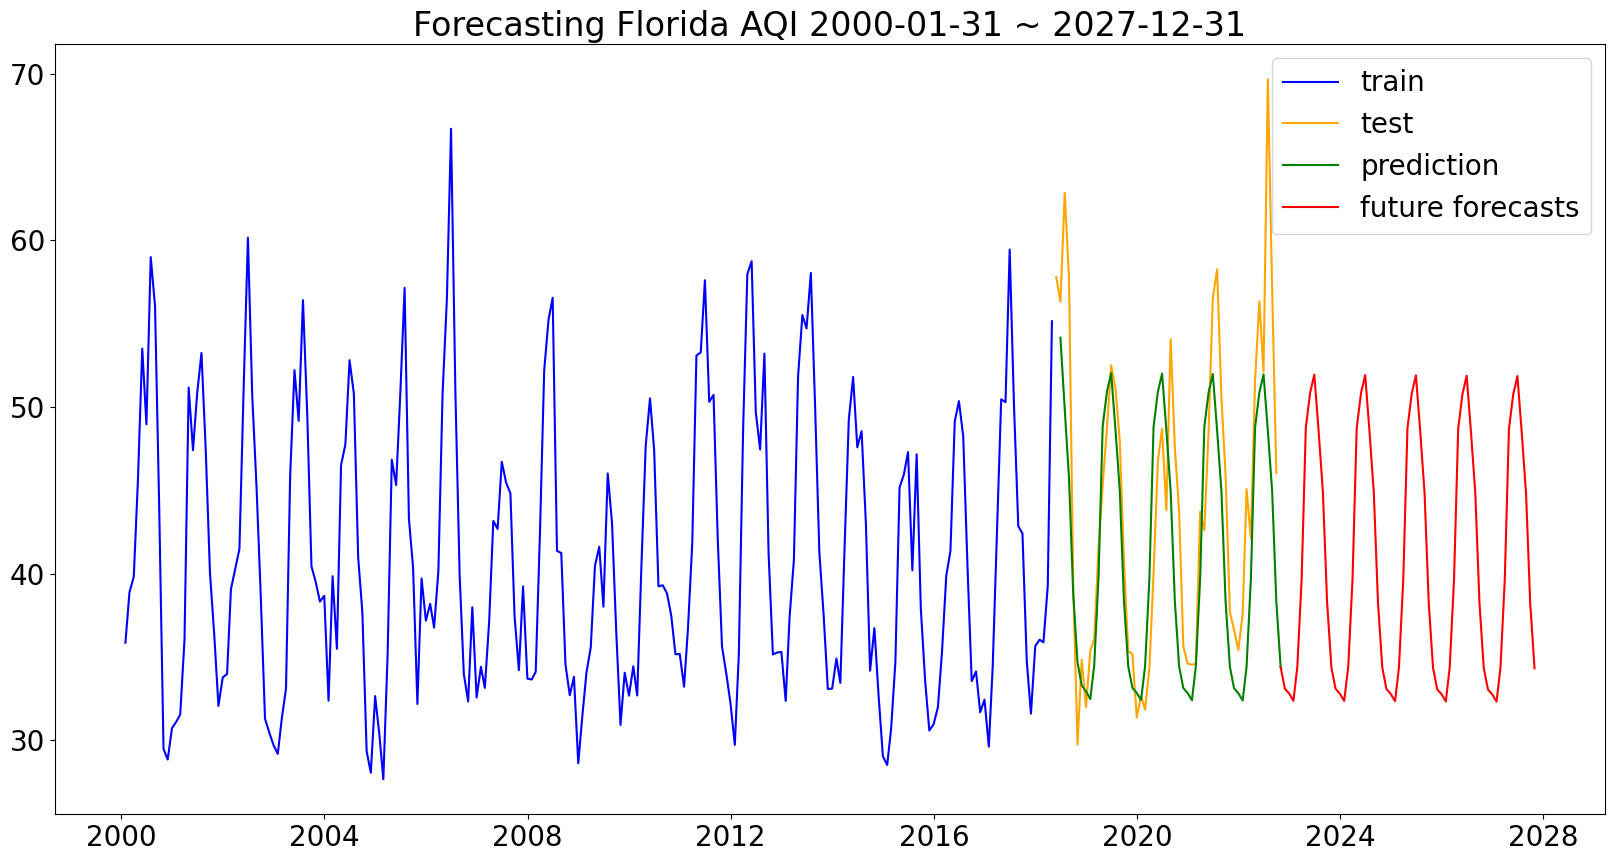

In [326]:
# plot predictions ad future forecasts

# Set figure size.
plt.figure(figsize=(20,10))

# Plot training data.
plt.plot(train.index, train.values, color = 'blue', label = 'train')

# Plot testing data.
plt.plot(test.index, test.values, color = 'orange', label = 'test')

# Plot predicted test values.
plt.plot(predictions, color = 'green', label = 'prediction')

# Plot predicted test values.
plt.plot(future_forecasts, color = 'red', label = 'future forecasts')

# Set label.
plt.title(label = 'Forecasting Florida AQI 2000-01-31 ~ 2027-12-31', fontsize=24)

# Resize tick marks.
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20);

In [327]:
print(f'R2 Score: {r2_score(test, predictions)}')
print(f'RMSE: {np.sqrt(mean_squared_error(test, predictions))}')
print(f'Mean AQI: {test.mean()}')

R2 Score: 0.14201168472172943
RMSE: 8.610508826715085
Mean AQI: aqi    44.308611
dtype: float64


### District of Columbia

In [99]:
aqi_dc = df_daily_state[df_daily_state['state_name'] == 'District Of Columbia']

In [100]:
aqi_dc.head()

,state_name,date,aqi
66256,District Of Columbia,2000-01-01,120.0
66257,District Of Columbia,2000-01-02,76.0
66258,District Of Columbia,2000-01-03,59.0
66259,District Of Columbia,2000-01-04,39.0
66260,District Of Columbia,2000-01-05,31.0


In [101]:
aqi_dc = aqi_dc.drop(['state_name'], axis=1)

In [102]:
# Set the index to be date
aqi_dc.set_index('date', inplace=True)

# resample by month
aqi_dc_m = aqi_dc.resample('M').mean()

In [103]:
aqi_dc_m

,aqi
date,
2000-01-31,56.967742
2000-02-29,61.344828
2000-03-31,50.709677
2000-04-30,48.066667
2000-05-31,82.612903
...,...
2022-04-30,42.800000
2022-05-31,45.741935
2022-06-30,61.333333


In [104]:
# run auto arima to find the best parameter
auto_arima(y=aqi_dc_m['aqi'],start_p=0,start_P=0,start_q=0,start_Q=0,seasonal=True, m=12).summary()

# the best model is: SARIMAX(1, 1, 1)x(1, 0, 1, 12)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  272
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -952.459
Date:                            Thu, 04 May 2023   AIC                           1914.919
Time:                                    20:40:22   BIC                           1932.930
Sample:                                01-31-2000   HQIC                          1922.150
                                     - 08-31-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4174      0.053      7.890      0.000       0.314       0.521
ma.L1         -0.9831      0.014    -70.345      0.000      -1.010      -0.956
ar.S.L12       0.9735      0.013     72.568      0.000       0.947       1.000
ma.S.L12      -0.7486      0.061    -12.287      0.000      -0.868      -0.629
sigma2        62.5038      3.124     20.010      0.000      56.382      68.626
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               221.97
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.53   Skew:                            -0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [106]:
len(aqi_dc_m)

272

In [164]:
#split data into train and test:
train = aqi_dc_m[:220]
test = aqi_dc_m[220:]

In [153]:
# Fit SARIMA model with the best parameter: (1, 1, 1)x(1, 0, [1], 12)
sarima = SARIMAX(train.astype(float).dropna() , order = (1, 1, 1), seasonal_order = (1, 0, 1, 12))

# Fit SARIMA model.
model = sarima.fit()

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [154]:
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                aqi   No. Observations:                  220
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -771.481
Date:                            Thu, 04 May 2023   AIC                           1552.963
Time:                                    20:46:34   BIC                           1569.908
Sample:                                01-31-2000   HQIC                          1559.807
                                     - 04-30-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4104      0.053      7.763      0.000       0.307       0.514
ma.L1         -0.9832      0.014   

In [169]:
# obtain predicted values
predictions = model.predict(start=220, end=272, typ='levels').rename('Predictions')

In [162]:
# obtain forecasted values
future_forecasts = model.predict(start=272, end=333, typ='levels').rename('future_forecasts')

In [167]:
train.shape, test.shape, predictions.shape

((220, 1), (52, 1), (52,))

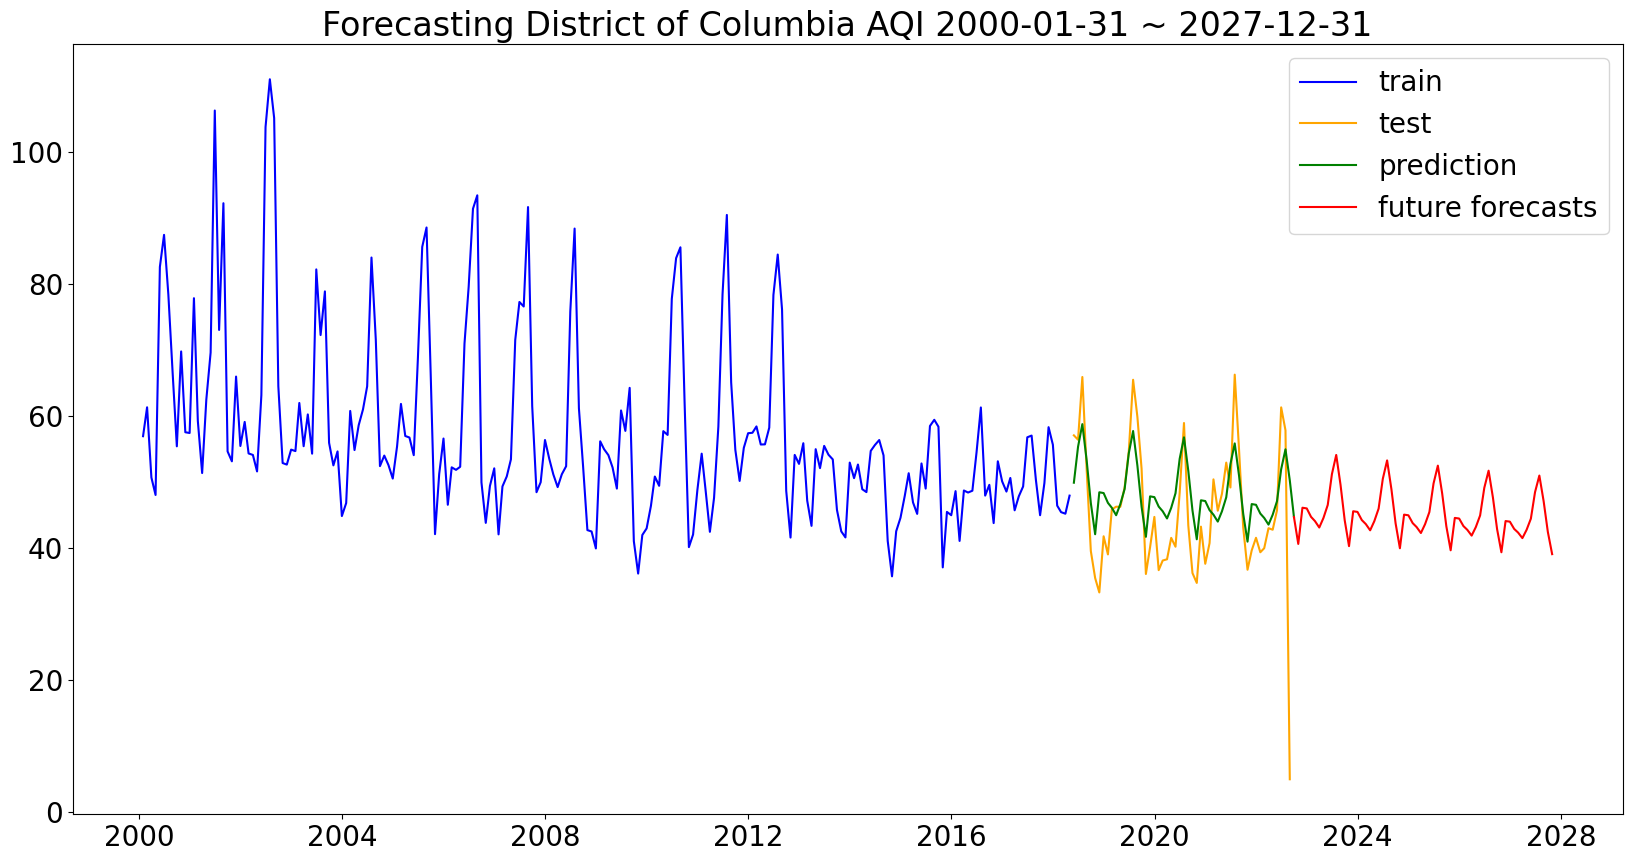

In [158]:
# plot predictions ad future forecasts

# Set figure size.
plt.figure(figsize=(20,10))

# Plot training data.
plt.plot(train.index, train.values, color = 'blue', label = 'train')

# Plot testing data.
plt.plot(test.index, test.values, color = 'orange', label = 'test')

# Plot predicted test values.
plt.plot(predictions, color = 'green', label = 'prediction')

# Plot predicted test values.
plt.plot(future_forecasts, color = 'red', label = 'future forecasts')

# Set label.
plt.title(label = 'Forecasting District of Columbia AQI 2000-01-31 ~ 2027-12-31', fontsize=24)

# Resize tick marks.
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20);

In [168]:
print(f'R2 Score: {r2_score(test, predictions)}')
print(f'RMSE: {np.sqrt(mean_squared_error(test, predictions))}')
print(f'Mean AQI: {test.mean()}')

R2 Score: 0.2861903282510734
RMSE: 8.696382442199411
Mean AQI: aqi    45.455562
dtype: float64


### AQI Percentage Change

In [312]:
df_daily_state[df_daily_state['state_name'] == 'Alabama'].sort_values('aqi').head()

,state_name,date,aqi
4349,Alabama,2011-11-28,9.333333
6184,Alabama,2016-12-06,11.666667
4763,Alabama,2013-01-15,12.000000
4357,Alabama,2011-12-06,12.000000
5476,Alabama,2014-12-29,12.333333


In [293]:
df_perc = pd.DataFrame()

In [294]:
df_perc = df_daily_state.groupby('state_name')['aqi'].max().reset_index()

In [295]:
df_perc.head(1)

,state_name,aqi
0,Alabama,168.583333


In [296]:
df_perc = df_perc.rename(columns={"aqi": "max_aqi"})

In [297]:
df_perc.set_index('state_name', inplace=True)

In [298]:
df_perc.head(1)

,max_aqi
state_name,
Alabama,168.583333


In [299]:
df_min = df_daily_state.groupby('state_name')['aqi'].min().reset_index()

In [300]:
df_min = df_min.rename(columns={"aqi": "min_aqi"})

In [301]:
df_min.head(1)

,state_name,min_aqi
0,Alabama,9.333333


In [302]:
df_min.set_index('state_name', inplace=True)

In [303]:
df_min.head(1)

,min_aqi
state_name,
Alabama,9.333333


In [304]:
df_p = pd.concat([df_perc, df_min], axis=1)

In [307]:
df_p.head(1)

,max_aqi,min_aqi
state_name,,
Alabama,168.583333,9.333333


In [308]:
df_p['percentage_change'] = df_p['max_aqi'] - df_p['min_aqi']

In [310]:
df_p.sort_values('percentage_change').head()

,max_aqi,min_aqi,percentage_change
state_name,,,
Nebraska,89.666667,5.333333,84.333333
Colorado,116.761905,16.470588,100.291317
Hawaii,105.000000,0.000000,105.000000
Florida,122.129032,10.500000,111.629032
Iowa,114.812500,3.000000,111.812500


In [311]:
df_p.sort_values('percentage_change').tail()

,max_aqi,min_aqi,percentage_change
state_name,,,
New Mexico,238.583333,13.866667,224.716667
Arizona,268.500000,18.454545,250.045455
Washington,316.321429,10.965517,305.355911
Oregon,403.652174,1.500000,402.152174
California,467.020000,27.698113,439.321887
